# Configure Conda Environment

Backlog: Please follow these steps carefully; otherwise, errors may occur unexpectedly.

In [6]:
!which python

/Users/dingyi/miniconda3/envs/SSDR/bin/python


In [2]:
# conda list --explicit > SSDR_spec_file.txt
# conda remove --name SSDR --all

# conda create --name SSDR python=3.8
# conda install -n SSDR ipykernel
# python -m ipykernel install --user --name SSDR --display-name "Python (SSDR)"

# conda activate SSDR
# conda install --name SSDR --file SSDR_spec_file.txt


# !which python
# !conda list  # For conda-installed packages
# conda install conda-forge::scikit-learn
# conda install conda-forge::tensorflow
# conda install conda-forge::pandas
# conda install conda-forge::numpy==1.19
# conda install conda-forge::matplotlib
# conda install pytorch::pytorch


# rm -rf build
# git clean -xdf

# export PATH=~/miniconda3/envs/SSDR/bin:$PATH

In [54]:
# Import the required libraries
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch
logging.basicConfig(level=logging.INFO)

# Generate the data properluy -> see ../data_generation/data_generation.py
# Send the job via ../data_generation/submit.sh to the cluster (BWUniCluster)

In [2]:
import numpy as np
import os
import logging

logging.basicConfig(level=logging.INFO)
# Load the data
def load_and_verify(scenario, rep, save_path):
    """
    Load and check the generated dataset for correctness.
    """
    scenario_index = '_'.join(map(str, scenario))
    
    # Define file paths
    X_path = f"{save_path}/X_{scenario_index}_rep{rep}.npy"
    Z_path = f"{save_path}/Z_{scenario_index}.npy"
    images_path = f"{save_path}/images_{scenario_index}_rep{rep}.npy"
    etas_path = f"{save_path}/etas_{scenario_index}.npy"
    responses_path = f"{save_path}/responses_{scenario_index}.npy"
    intercepts_path = f"{save_path}/intercepts_{scenario_index}.npy"
    unstructured_effects_path = f"{save_path}/unstructured_effects_{scenario_index}.npy"

    # Check if files exist
    files = [X_path, Z_path, images_path, etas_path, responses_path, intercepts_path, unstructured_effects_path]
    for file in files:
        if not os.path.exists(file):
            logging.warning(f"File not found: {file}")
            return False

    # Load the files
    X = np.load(X_path)
    Z = np.load(Z_path)
    images = np.load(images_path)
    etas = np.load(etas_path)
    responses = np.load(responses_path)
    intercepts = np.load(intercepts_path)
    unstructured_effects = np.load(unstructured_effects_path)

    # Perform sanity checks
    logging.info(f"Verifying scenario {scenario_index} - Replication {rep}")
    logging.info(f"X shape: {X.shape}, Z shape: {Z.shape}, Images shape: {images.shape}")
    logging.info(f"Etas shape: {etas.shape}, Responses shape: {responses.shape}")
    logging.info(f"Intercepts: {intercepts}")
    logging.info(f"Unstructured Effects shape: {unstructured_effects.shape}")

    # Sanity checks
    assert X.shape[0] == Z.shape[0] == etas.shape[0] == responses.shape[0], "Shape mismatch in data"
    assert images.shape[0] == X.shape[0], "Images and data points mismatch"

    logging.info(f"Scenario {scenario_index} - Replication {rep} verified successfully.\n")
    return True

def verify_all_datasets(scenarios, save_path, n_rep=4):
    """
    Iterate over all saved datasets and verify them.
    """
    logging.info("Starting dataset verification process...")
    errors = 0
    for scenario in scenarios:
        for rep in range(n_rep):
            try:
                success = load_and_verify(scenario, rep, save_path)
                if not success:
                    errors += 1
            except Exception as e:
                logging.error(f"Error verifying dataset {scenario} - Rep {rep}: {str(e)}")
                errors += 1

    if errors == 0:
        logging.info("All datasets verified successfully.")
    else:
        logging.warning(f"Verification completed with {errors} errors.")

# ---------------------------
# Scenario Setup for Verification
# ---------------------------

scenarios = [
    (100, "poisson", 1, 2), (500, "poisson", 1, 2), (1000, "poisson", 1, 2),
    (100, "poisson", 1, 4), (500, "poisson", 1, 4), (1000, "poisson", 1, 4),
    (100, "gamma", 2, 2), (500, "gamma", 2, 2), (1000, "gamma", 2, 2), 
    (100, "gamma", 2, 4), (500, "gamma", 2, 4), (1000, "gamma", 2, 4), 
    (100, "gaussian", 2, 2), (500, "gaussian", 2, 2), (1000, "gaussian", 2, 2),
    (100, "gaussian", 2, 4), (500, "gaussian", 2, 4), (1000, "gaussian", 2, 4)
]

# save_path = os.path.join(os.environ["TMPDIR"], "output") # remotely
save_path = "../data_generation/output" # locally
# Verify all datasets
verify_all_datasets(scenarios, save_path, n_rep=100)


INFO:root:Starting dataset verification process...
INFO:root:Verifying scenario 100_poisson_1_2 - Replication 0
INFO:root:X shape: (100, 2), Z shape: (100, 2), Images shape: (100, 28, 28)
INFO:root:Etas shape: (100, 1), Responses shape: (100,)
INFO:root:Intercepts: [-3.0056114]
INFO:root:Unstructured Effects shape: (100, 1)
INFO:root:Scenario 100_poisson_1_2 - Replication 0 verified successfully.

INFO:root:Verifying scenario 100_poisson_1_2 - Replication 1
INFO:root:X shape: (100, 2), Z shape: (100, 2), Images shape: (100, 28, 28)
INFO:root:Etas shape: (100, 1), Responses shape: (100,)
INFO:root:Intercepts: [-2.15775651]
INFO:root:Unstructured Effects shape: (100, 1)
INFO:root:Scenario 100_poisson_1_2 - Replication 1 verified successfully.

INFO:root:Verifying scenario 100_poisson_1_2 - Replication 2
INFO:root:X shape: (100, 2), Z shape: (100, 2), Images shape: (100, 28, 28)
INFO:root:Etas shape: (100, 1), Responses shape: (100,)
INFO:root:Intercepts: [-2.29627197]
INFO:root:Unstructu

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
save_path = "../data_generation/output_local" # locally
# ---------------------------
# Helper Functions for Visualization
# ---------------------------

def variance_of_difference(img1, img2):
    difference = img1 - img2
    return np.var(difference)

def mean_absolute_error(img1, img2):
    return np.mean(np.abs(img1 - img2))

def pixel_difference_count(img1, img2, threshold=0.01):
    return np.sum(np.abs(img1 - img2) > threshold)

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(layer_sizes[0], activation=activation),
        Dense(layer_sizes[1], activation=activation),
        Dense(1, activation=None)
    ])
    model.compile(optimizer='adam', loss='mse')  # Compile the model

    return model

def plot_linear_effects(X, linear_effects1, linear_effects2, scenario1, scenario2, K):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    colors = plt.cm.viridis(np.linspace(0, 1, K * linear_effects1.shape[0]))

    color_idx = 0
    for k in range(K):
        for i in range(linear_effects1.shape[0]):  # Iterate over I
            axes[0].plot(X[i, :, k], linear_effects1[i, :, k], 'o', 
                         label=f'Linear Effect {k+1}, X{i+1} for low SNR', color=colors[color_idx])
            axes[1].plot(X[i, :, k], linear_effects2[i, :, k], 'o', 
                         label=f'Linear Effect {k+1}, X{i+1} for high SNR', color=colors[color_idx])
            color_idx += 1
    
    axes[0].set_title(f"Linear Effects (low SNR) - Scenario {scenario1}")
    axes[0].set_xlabel("X (scaled)")
    axes[0].set_ylabel("True Effect Value")
    axes[0].legend()

    axes[1].set_title(f"Linear Effects (high SNR) - Scenario {scenario2}")
    axes[1].set_xlabel("X (scaled)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def plot_nonlinear_effects(Z, nonlinear_effects1, nonlinear_effects2, scenario1, scenario2, K):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    colors = plt.cm.viridis(np.linspace(0, 1, K * nonlinear_effects1.shape[0]))

    color_idx = 0
    for k in range(K):
        for j in range(nonlinear_effects1.shape[0]):  # Iterate over J
            axes[0].plot(Z[j, :, k], nonlinear_effects1[j, :, k], 'o', 
                         label=f'Nonlinear Effect {k+1}, Z{j+1} for low SNR', color=colors[color_idx])
            axes[1].plot(Z[j, :, k], nonlinear_effects2[j, :, k], 'o', 
                         label=f'Nonlinear Effect {k+1}, Z{j+1} for high SNR', color=colors[color_idx])
            color_idx += 1
    
    axes[0].set_title(f"Nonlinear Effects (low SNR) - Scenario {scenario1}")
    axes[0].set_xlabel("Z (scaled)")
    axes[0].set_ylabel("True Effect Value")
    axes[0].legend()

    axes[1].set_title(f"Nonlinear Effects (high SNR) - Scenario {scenario2}")
    axes[1].set_xlabel("Z (scaled)")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

def plot_unstructured_image(images_snr1, images_snr2, images_scaled_SNR1, images_scaled_SNR2, a_U_snr1, a_U_snr2, index=0):
    # Recover the original images by subtracting the Gaussian noise
    original_image_snr1 = images_snr1[index] - a_U_snr1[index]
    original_image_snr2 = images_snr2[index] - a_U_snr2[index]
    
    original_image_scaled_snr1 = images_scaled_SNR1[index]
    original_image_scaled_snr2 = images_scaled_SNR2[index]
    
    # var_diff = variance_of_difference(original_image_snr1, original_image_snr2)
    # mae = mean_absolute_error(original_image_snr1, original_image_snr2)
    # pixel_diff = pixel_difference_count(original_image_snr1, original_image_snr2)
    # logging.info(f"Variance={var_diff:.4f}\nMAE={mae:.4f}\nPixel Diff={pixel_diff}")
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # Plot original images
    axes[0, 0].imshow(original_image_snr1, cmap="gray")
    axes[0, 0].set_title(f"Original Image (SNR=1)\n")
    axes[0, 0].axis('off')

    axes[0, 1].imshow(original_image_snr2, cmap="gray")
    axes[0, 1].set_title(f"Original Image (SNR=2)\n")
    axes[0, 1].axis('off')

    # Plot noisy images
    axes[1, 0].imshow(original_image_scaled_snr1, cmap="gray")
    axes[1, 0].set_title(f"Noisy Image (SNR=1)\n")
    axes[1, 0].axis('off')

    axes[1, 1].imshow(original_image_scaled_snr2, cmap="gray")
    axes[1, 1].set_title(f"Noisy Image (SNR=2)\n")
    axes[1, 1].axis('off')

    plt.tight_layout()
    plt.show()
    
# def plot_linear_effects(X1, X2, linear_effects1, linear_effects2, scenario1, scenario2, K):
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
#     for k in range(K):
#         for i in range(linear_effects1.shape[2]):  # Iterate over I
#             axes[0].plot(X1[i, :, i], linear_effects1[i, :, k], 'o', 
#                          label=f'Effect {k+1}, X{i+1} for low SNR', color="turquoise" if k == 0 else "violet")
#             axes[1].plot(X2[i, :, k], linear_effects2[i, :, k], 'o', 
#                          label=f'Effect {k+1}, X{i+1} for high SNR', color="orange" if k == 0 else "blue")
    
#     axes[0].set_title(f"Linear Effects (low SNR) - Scenario {scenario1}")
#     axes[0].set_xlabel("X (scaled)")
#     axes[0].set_ylabel("True Effect Value")
#     axes[0].legend()

#     axes[1].set_title(f"Linear Effects (high SNR) - Scenario {scenario2}")
#     axes[1].set_xlabel("X (scaled)")
#     axes[1].legend()

#     plt.tight_layout()
#     plt.show()

# def plot_nonlinear_effects(Z1, Z2, nonlinear_effects1, nonlinear_effects2, scenario1, scenario2, K):
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
    
#     for k in range(K):
#         for j in range(nonlinear_effects1.shape[2]):  # Iterate over J
#             axes[0].plot(Z1[j, :, k], nonlinear_effects1[j, :, k], 'o', 
#                          label=f'Nonlinear Effect {k+1}, Z{j+1} for low SNR', color="turquoise" if k == 0 else "violet")
#             axes[1].plot(Z2[j, :, k], nonlinear_effects2[k, :, j], 'o', 
#                          label=f'Nonlinear Effect {k+1}, Z{j+1} for high SNR', color="orange" if k == 0 else "blue")
    
#     axes[0].set_title(f"Nonlinear Effects (low SNR) - Scenario {scenario1}")
#     axes[0].set_xlabel("Z (scaled)")
#     axes[0].set_ylabel("True Effect Value")
#     axes[0].legend()

#     axes[1].set_title(f"Nonlinear Effects (high SNR) - Scenario {scenario2}")
#     axes[1].set_xlabel("Z (scaled)")
#     axes[1].legend()

#     plt.tight_layout()
#     plt.show()

# def plot_unstructured_image(image_snr2, image_snr4, scenario):
#     var_diff = variance_of_difference(image_snr2, image_snr4)
#     mae = mean_absolute_error(image_snr2, image_snr4)
#     pixel_diff = pixel_difference_count(image_snr2, image_snr4)
#     logging.info(f"Variance={var_diff:.4f}\nMAE={mae:.4f}\nPixel Diff={pixel_diff}")
#     fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#     axes[0].imshow(image_snr2, cmap="gray")
#     axes[0].set_title(f"Unstructured Effect (SNR=2)\n")
#     axes[0].axis('off')

#     axes[1].imshow(image_snr4, cmap="gray")
#     axes[1].set_title(f"Unstructured Effect (SNR=4)\n")
#     axes[1].axis('off')

#     plt.colorbar(axes[1].imshow(image_snr4, cmap="gray"))
#     plt.tight_layout()
#     plt.show()



# ---------------------------
# Generate Random Scenario for Visualization and Compare SNR
# ---------------------------

def random_scenario_plot(scenarios, alpha, beta, n_rep, SNR_compare=[0.5,20], grid_size=28):
    random_scenario = random.choice(scenarios)
    n_samples, distribution = random_scenario
    logging.info(f"Comparing SNR in {SNR_compare} for scenario: {random_scenario}")
    K = 2 if distribution in ["gamma", "gaussian"] else 1
   

    rep = random.randint(0, n_rep)
    scenario = '_'.join(map(str, random_scenario))+f"_rep{rep}"
    scenario_SNR1 = scenario+f"_SNR{SNR_compare[0]}"
    scenario_SNR2 = scenario+f"_SNR{SNR_compare[1]}"
    logging.info(f"Visualizing Scenario: {random_scenario}, Rep: {rep}")
    
    # Load the saved data from files
    # Define file paths
    dnn_model1 = dnn_model2 = build_dnn(grid_size * grid_size)
    dnn_model1.load_weights(f"{save_path}/dnn_model_{scenario_SNR1}.keras")
    dnn_model2.load_weights(f"{save_path}/dnn_model_{scenario_SNR2}.keras")
    
    # common basis
    X_path = f"{save_path}/X_{scenario}.npy"
    Z_path = f"{save_path}/Z_{scenario}.npy"
    images = f"{save_path}/images_{scenario}.npy"
    
    # lower SNR
    a_X_SNR1_path = f"{save_path}/a_X_{scenario_SNR1}.npy"
    a_Z_SNR1_path = f"{save_path}/a_Z_{scenario_SNR1}.npy"
    images_scaled_SNR1_path = f"{save_path}/images_scaled_{scenario_SNR1}.npy"
    a_U_SNR1_path = f"{save_path}/a_U_{scenario_SNR1}.npy"
    
    U_k_SNR1_path = f"{save_path}/U_k_{scenario_SNR1}.npy"
    psi_k_SNR1_path = f"{save_path}/psi_k_{scenario_SNR1}.npy"
    b_k_SNR1_path = f"{save_path}/b_k_{scenario_SNR1}.npy"
    
    etas_SNR1_path = f"{save_path}/etas_{scenario_SNR1}.npy"
    responses_SNR1_path = f"{save_path}/responses_{scenario_SNR1}.npy"
    
    linear_effects_SNR1_path = f"{save_path}/linear_effects_{scenario_SNR1}.npy"
    nonlinear_effects_SNR1_path = f"{save_path}/nonlinear_effects_{scenario_SNR1}.npy"
    unstructured_effects_SNR1_path = f"{save_path}/unstructured_effects_{scenario_SNR1}.npy"

    # higher SNR
    a_X_SNR2_path = f"{save_path}/a_X_{scenario_SNR2}.npy"
    a_Z_SNR2_path = f"{save_path}/a_Z_{scenario_SNR2}.npy"
    images_scaled_SNR2_path = f"{save_path}/images_scaled_{scenario_SNR2}.npy"
    a_U_SNR2_path = f"{save_path}/a_U_{scenario_SNR2}.npy"
    
    U_k_SNR2_path = f"{save_path}/U_k_{scenario_SNR2}.npy"
    psi_k_SNR2_path = f"{save_path}/psi_k_{scenario_SNR2}.npy"
    b_k_SNR2_path = f"{save_path}/b_k_{scenario_SNR2}.npy"
    
    etas_SNR2_path = f"{save_path}/etas_{scenario_SNR2}.npy"
    responses_SNR2_path = f"{save_path}/responses_{scenario_SNR2}.npy"
    
    linear_effects_SNR2_path = f"{save_path}/linear_effects_{scenario_SNR2}.npy"
    nonlinear_effects_SNR2_path = f"{save_path}/nonlinear_effects_{scenario_SNR2}.npy"
    unstructured_effects_SNR2_path = f"{save_path}/unstructured_effects_{scenario_SNR2}.npy"
    
    
    # Check if files exist
    files = [X_path,Z_path,images, a_X_SNR1_path, a_Z_SNR1_path, images_scaled_SNR1_path,
             a_U_SNR1_path, U_k_SNR1_path, psi_k_SNR1_path, b_k_SNR1_path, etas_SNR1_path, responses_SNR1_path,
             linear_effects_SNR1_path, nonlinear_effects_SNR1_path, unstructured_effects_SNR1_path,
             a_X_SNR2_path, a_Z_SNR2_path, images_scaled_SNR2_path,
             a_U_SNR2_path, U_k_SNR2_path,  psi_k_SNR2_path, b_k_SNR2_path, etas_SNR2_path, responses_SNR2_path,
             linear_effects_SNR2_path, nonlinear_effects_SNR2_path, unstructured_effects_SNR2_path]
    
    for file in files:
        if not os.path.exists(file):
            logging.warning(f"File not found: {file}")
            return False

    # Load the files
    X_SNR = np.load(X_path)
    Z_SNR = np.load(Z_path)
    
    # lower SNR
    a_X_SNR1 = np.load(a_X_SNR1_path)
    a_Z_SNR1 = np.load(a_Z_SNR1_path)
    images_scaled_SNR1 = np.load(images_scaled_SNR1_path)
    a_U_SNR1 = np.load(a_U_SNR1_path)
    U_k_SNR1 = np.load(U_k_SNR1_path)
    psi_k_SNR1 = np.load(psi_k_SNR1_path)
    b_k_SNR1 = np.load(b_k_SNR1_path)
    etas_SNR1 = np.load(etas_SNR1_path)
    responses_SNR1 = np.load(responses_SNR1_path)
    linear_effects_SNR1 = np.load(linear_effects_SNR1_path)
    print(linear_effects_SNR1)
    nonlinear_effects_SNR1 = np.load(nonlinear_effects_SNR1_path)
    unstructured_effects_SNR1 = np.load(unstructured_effects_SNR1_path)
    # higher SNR
    a_X_SNR2 = np.load(a_X_SNR2_path)
    a_Z_SNR2 = np.load(a_Z_SNR2_path)
    images_scaled_SNR2 = np.load(images_scaled_SNR2_path)
    a_U_SNR2 = np.load(a_U_SNR2_path)
    U_k_SNR2 = np.load(U_k_SNR2_path)
    psi_k_SNR2 = np.load(psi_k_SNR2_path)
    b_k_SNR2 = np.load(b_k_SNR2_path)
    etas_SNR2 = np.load(etas_SNR2_path)
    responses_SNR2 = np.load(responses_SNR2_path)
    linear_effects_SNR2 = np.load(linear_effects_SNR2_path)
    print(linear_effects_SNR2)
    nonlinear_effects_SNR2 = np.load(nonlinear_effects_SNR2_path)
    unstructured_effects_SNR2 = np.load(unstructured_effects_SNR2_path)
    
    # Replicate linear effects
    # Sanity checks for linear effects
    for i in range(linear_effects_SNR1.shape[0]):
        for k in range(linear_effects_SNR1.shape[2]):
            assert np.min(linear_effects_SNR1[i, :, k]) >= -1 and np.max(linear_effects_SNR1[i, :, k]) <= 1,\
                f"Linear effect column {i} for K={k} and SNR={SNR_compare[0]} is out of range!"
            assert np.min(linear_effects_SNR2[i, :, k]) >= -1 and np.max(linear_effects_SNR2[i, :, k]) <= 1,\
                f"Linear effect column {i} for K={k} and SNR={SNR_compare[1]} is out of range!"

    # Sanity checks for nonlinear effects
    for j in range(nonlinear_effects_SNR1.shape[2]):
        assert np.min(nonlinear_effects_SNR1[j, :, :]) >= -1 and np.max(nonlinear_effects_SNR1[j, :, :]) <= 1, f"Nonlinear effect column {j} for SNR=0.5 is out of range!"
        assert np.min(nonlinear_effects_SNR2[j, :, :]) >= -1 and np.max(nonlinear_effects_SNR2[j, :, :]) <= 1, f"Nonlinear effect column {j} for SNR=2 is out of range!"

    # Sanity checks for unstructured effects
    for k in range(unstructured_effects_SNR1.shape[1]):
        assert np.min(unstructured_effects_SNR1[:, k]) >= -1 and np.max(unstructured_effects_SNR1[:, k]) <= 1, f"Unstructured effect column {k} for SNR=0.5 is out of range!"
        assert np.min(unstructured_effects_SNR2[:, k]) >= -1 and np.max(unstructured_effects_SNR2[:, k]) <= 1, f"Unstructured effect column {k} for SNR=2 is out of range!"

    # # Generate unstructured image using Gaussian Process
    # x = np.linspace(0, 1, grid_size)
    # y = np.linspace(0, 1, grid_size)
    # X_grid, Y_grid = np.meshgrid(x, y)
    # coords = np.vstack([X_grid.ravel(), Y_grid.ravel()]).T

    # kernel = RBF(length_scale=0.2)
    # gp = GaussianProcessRegressor(kernel=kernel)
    # image_snr2 = gp.sample_y(coords, n_samples=1).reshape(grid_size, grid_size)
    # image_snr4 = image_snr2 * 2  # Simulate stronger signal for SNR=4
    # image_snr2 = scale_to_range(image_snr2, -1, 1)
    # image_snr4 = scale_to_range(image_snr4, -1, 1)
    # snr_image2 = calculate_snr(image_snr2)
    # snr_image4 = calculate_snr(image_snr4)
    # logging.info(f"SNR (Unstructured Image) - SNR=2: {snr_image2:.4f}, SNR=4: {snr_image4:.4f}")

    # Plot the results dynamically based on K
    plot_linear_effects(X_SNR, linear_effects_SNR1, linear_effects_SNR2, scenario_SNR1, scenario_SNR2, K)
    plot_nonlinear_effects(Z_SNR, nonlinear_effects_SNR1, nonlinear_effects_SNR2,scenario_SNR1,scenario_SNR2, K)
    # plot_unstructured_image(images_SNR1, images_SNR2, images_scaled_SNR1, images_scaled_SNR2, a_U_SNR1, a_U_SNR2, index=rep)



# ---------------------------
# Run Random Visualization for Comparison
# ---------------------------
# scenarios = [
#     (100, "poisson", 1, 2), (500, "poisson", 1, 2), (1000, "poisson", 1, 2),
#     (100, "poisson", 1, 4), (500, "poisson", 1, 4), (1000, "poisson", 1, 4),
#     (100, "gamma", 2, 2), (500, "gamma", 2, 2), (1000, "gamma", 2, 2), 
#     (100, "gamma", 2, 4), (500, "gamma", 2, 4), (1000, "gamma", 2, 4), 
#     (100, "gaussian", 2, 2), (500, "gaussian", 2, 2), (1000, "gaussian", 2, 2),
#     (100, "gaussian", 2, 4), (500, "gaussian", 2, 4), (1000, "gaussian", 2, 4)
# ]
scenarios = [
    (100, "poisson")#, (500, "poisson"), (1000, "poisson"),
    # (100, "gamma"), (500, "gamma"), (1000, "gamma"), 
    # (100, "gaussian"), (500, "gaussian"), (1000, "gaussian")
]

# Linear effect coefficients
alpha = {0: [3, -1], 1: [-0.5, 6]}

# Nonlinear effect functions
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

beta = {
    0: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    1: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}

random_scenario_plot(scenarios, alpha, beta, n_rep=0, SNR_compare=[2,20],grid_size=28)


INFO:root:Comparing SNR in [2, 20] for scenario: (100, 'poisson')
INFO:root:Visualizing Scenario: (100, 'poisson'), Rep: 0


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../data_generation/output_local/dnn_model_100_poisson_rep0_SNR2.keras', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [36]:
X = np.load("../data_generation/output_local/X_n_10_rep_0_rep0.npy")
X

array([[[0.94952024, 0.74611421],
        [0.        , 0.50727665],
        [0.71510928, 0.27238674],
        [0.59767305, 0.54586899],
        [0.51146   , 0.45241863],
        [0.65295955, 0.90709391],
        [0.19153354, 0.84941506],
        [0.58550071, 0.6569568 ],
        [0.13491965, 0.55464421],
        [1.        , 0.15366503]],

       [[0.        , 0.05371816],
        [0.51431469, 1.        ],
        [0.71089524, 0.83671904],
        [0.47605372, 0.77377038],
        [0.39115273, 0.59388339],
        [0.39205373, 0.32741667],
        [0.48374601, 0.34418772],
        [0.7532502 , 0.49802731],
        [0.5450617 , 0.37593637],
        [0.74133078, 0.28554795]]])

In [39]:
linear_effects = np.load("../data_generation/output_local/linear_effects_n_10_rep_0.npy")
linear_effects

array([[[ 0.06668962, -0.88740441],
        [-0.77692217, -0.8520381 ],
        [-0.14157541, -0.81725634],
        [-0.24591292, -0.85775273],
        [-0.32250986, -0.84391489],
        [-0.19679302, -0.91124178],
        [-0.60675207, -0.90270087],
        [-0.25672758, -0.87420226],
        [-0.65705131, -0.85905213],
        [ 0.11153892, -0.7996764 ]],

       [[-0.77692217, -0.68146918],
        [-0.92923836,  1.        ],
        [-0.98745642,  0.70986245],
        [-0.91790724,  0.59800758],
        [-0.89276349,  0.2783624 ],
        [-0.89303033, -0.19512823],
        [-0.92018534, -0.16532737],
        [-1.        ,  0.1080336 ],
        [-0.9383442 , -0.1089125 ],
        [-0.99647002, -0.26952569]]])

In [33]:
etas = np.load("../data_generation/output_local/etas_n_10_rep_0_SNR1_rep0.npy")
etas

array([[-4.43609798,  0.        ],
       [-5.24806424,  0.        ],
       [-4.6738208 ,  0.        ],
       [-3.09637812,  0.        ],
       [-3.96204327,  0.        ],
       [-4.40726769,  0.        ],
       [-3.44679968,  0.        ],
       [-5.68311229,  0.        ],
       [-7.41200811,  0.        ],
       [-6.60129621,  0.        ]])

In [6]:
import numbers
isinstance(res[0], numbers.Number)


True

In [2]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor

# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch
logging.basicConfig(level=logging.INFO)
import os
from sympy import *
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# ---------------------------
# Helper Functions
# ---------------------------

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(layer_sizes[0], activation=activation),
        Dense(layer_sizes[1], activation=activation),
        Dense(1, activation=None)
    ])
    model.compile(optimizer='adam', loss='mse')  # Compile the model

    return model

def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None): # , SNR_compare=[2,4]
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel, random_state=random_state)
    intensity = gp.sample_y(coords, n_samples=1, random_state=random_state).reshape(grid_size, grid_size)
    
    # # Add Gaussian noise
    # range_effects = np.ptp(intensity)
    # a_U1 = np.random.normal(0, range_effects / SNR_compare[0], size=intensity.shape)
    # a_U2 = np.random.normal(0, range_effects / SNR_compare[1], size=intensity.shape)
    # intensity1 = scale_to_range(intensity + a_U1)
    # intensity2 = scale_to_range(intensity + a_U2)
    intensity_scaled = scale_to_range(intensity)
    
    return intensity_scaled # intensity, a_U1, a_U2, intensity1, intensity2

# ---------------------------
# Simulation Functions
# ---------------------------

def generate_linear_effects(n_samples, I, K, alpha, random_state=None): # SNR_compare, 
    np.random.seed(random_state)
    X = np.random.normal(size=(I, n_samples, K)) # The same basis for all SNRs
    # a_X1 = np.zeros((I, n_samples, K))  # Gaussian noise for each data point and K
    # a_X2 = np.zeros((I, n_samples, K))
    X_scaled = np.zeros_like(X)
    linear_effects1 = np.zeros((I, n_samples, K))
    # linear_effects2 = np.zeros((I, n_samples, K))
    
    for i in range(I):
        X_scaled[i] = scale_to_range(X[i], 0, 1)
        for k in range(K):
            linear_effects1[i, :, k] = alpha[k][i] * X_scaled[i][:, k]
            # linear_effects2[i, :, k] = alpha[k][i] * X_scaled[i][:, k]
            # range_effects = np.ptp(linear_effects1[i, :, k])
            # a_X1[i][:, k] = np.random.normal(0, range_effects / SNR_compare[0], size=n_samples)
            # a_X2[i][:, k] = np.random.normal(0, range_effects / SNR_compare[1], size=n_samples)
        # linear_effects1[i] += a_X1[i]  # Add noise to each data point
        # linear_effects2[i] += a_X2[i]
        
    return X_scaled, scale_to_range(linear_effects1) # a_X1, a_X2, scale_to_range(linear_effects2)

def generate_nonlinear_effects(n_samples, J, K, beta, random_state=None): #SNR_compare, 
    np.random.seed(random_state)
    Z = np.random.uniform(0, 1, size=(J, n_samples, K)) # doesn't need to scale
    # a_Z1 = np.zeros((J, n_samples, K))  # Gaussian noise for each data point and K
    # a_Z2 = np.zeros((J, n_samples, K))
    nonlinear_effects1 = np.zeros((J, n_samples, K))
    # nonlinear_effects2 = np.zeros((J, n_samples, K))

    for j in range(J):
        for k in range(K):
            nonlinear_effects1[j, :, k] = beta[k][j](Z[j][:, k])
        #     nonlinear_effects2[j, :, k] = beta[k][j](Z[j][:, k])
        #     range_effects = np.ptp(beta[k][j](Z[j][:, k]))
        #     a_Z1[j][:, k] = np.random.normal(0, range_effects / SNR_compare[0], size=n_samples)  # Gaussian noise for each Z
        #     a_Z2[j][:, k] = np.random.normal(0, range_effects / SNR_compare[1], size=n_samples)
        # nonlinear_effects1[j] += a_Z1[j]  # Add noise to each data point
        # nonlinear_effects2[j] += a_Z2[j]
        
    return Z, scale_to_range(nonlinear_effects1) #a_Z1, a_Z2, , scale_to_range(nonlinear_effects2)

def generate_unstructured_effects(images, dnn_model, K):
    n_samples = len(images)
    # print(n_samples)
    unstructured_effects = np.zeros((n_samples, K))
    
    # Predict unstructured effects using the DNN model
    predictions = dnn_model.predict(images)

    # Extract the penultimate layer's output
    penultimate_layer_model = Model(inputs=dnn_model.input, outputs=dnn_model.layers[-2].output)
    penultimate_output = penultimate_layer_model.predict(images)

    # Extract the weights and bias from the final layer
    final_layer_weights, final_layer_bias = dnn_model.layers[-1].get_weights()

    for k in range(K):
        unstructured_effects[:, k] = scale_to_range(predictions[:, 0])

    return unstructured_effects, penultimate_output, final_layer_weights, final_layer_bias # \hat{U}_k, \hat{\psi}_k, \hat{b}_k

def combine_effects(scenario, rep, save_path, unstructured_effects, linear_effects, nonlinear_effects, distribution="poisson", SNR_list=[1,8]):
    # Debug statements to check the shapes of the inputs
    # print(f"unstructured_effects shape: {unstructured_effects.shape}")
    # print(f"linear_effects shape: {linear_effects.shape}")
    # print(f"nonlinear_effects shape: {nonlinear_effects.shape}")
    # if compute_type == 'concurrent':
    #     # Use pool.starmap to pass multiple arguments to the method
    #     with ThreadPoolExecutor() as inner_executor:
    #         inner_executor.map(add_SNR, [(scenario, rep, n_cores, save_path, unstructured_effects, linear_effects, nonlinear_effects, distribution, s) 
    #                                     for s in SNR_list])
    # if compute_type == 'serial':
    for s in SNR_list:
        add_SNR(scenario, rep, save_path, unstructured_effects, linear_effects, nonlinear_effects, distribution, s)
    
    
    # Save datasets and responses
    # save_results(scenario, SNR_compare, rep, X, a_X1, a_X2, Z, a_Z1, a_Z2, images, images_scaled1, images_scaled2,
    #              a_U1, a_U2, dnn_model1, dnn_model2, penultimate_output1, final_layer_weights1,
    #              final_layer_bias1, penultimate_output2, final_layer_weights2, final_layer_bias2,
    #              linear_effects1, nonlinear_effects1, unstructured_effects1, linear_effects2,
    #              nonlinear_effects2, unstructured_effects2, etas1, responses1, etas2, responses2, save_path)
    

    # return a1, a2, etas1, etas2

def add_SNR(scenario_index, rep, save_path, unstructured_effects, linear_effects, nonlinear_effects, distribution="poisson", SNR=1):
    os.makedirs(save_path, exist_ok=True)
    scenario_index += f"_SNR{SNR}_rep{rep}"
    K = linear_effects.shape[2]
    N = linear_effects.shape[1]  # Number of data points
    # etas1 = np.zeros((N, K))
    # etas2 = np.zeros((N, K))
    etas = np.zeros((N, K))
    k = 0
    etas[:, k] = linear_effects[:, :, k].sum(axis=0) + nonlinear_effects[:, :, k].sum(axis=0) + unstructured_effects[:, k]
    # temp0 = linear_effects[:, :, k].sum(axis=0) + nonlinear_effects[:, :, k].sum(axis=0) + unstructured_effects[:, k]
    # etas1[:, k] = temp0
    # etas2[:, k] = temp0
    # range_etas = np.ptp(temp0)
    range_etas = np.ptp(etas[:, k])
    std_eta = np.std(etas[:, k])
    if distribution == "poisson" or distribution == "gamma":
        a = std_eta * SNR - range_etas
        etas[:, k] += a
        
        # a1 = solve(Eq(x**2+(2*range_etas-SNR_compare[0]**2)*x+range_etas**2-temp0*SNR_compare[0]**2,0),x)
        # a2 = solve(Eq(x**2+(2*range_etas-SNR_compare[1]**2)*x+range_etas**2-temp0*SNR_compare[1]**2,0),x)
        # etas1[:, k] += a1
        # etas2[:, k] += a2
        
    # elif distribution == "gamma":
    #     # std_eta = np.std(temp0)
        
    #     a = std_eta * SNR - range_etas
    #     etas[:, k] += a
        # a1 = std_eta * SNR_compare[0] - range_etas
        # a2 = std_eta * SNR_compare[1] - range_etas
        # etas1[:, k] += a1
        # etas2[:, k] += a2
    elif distribution == "gaussian":
        for k in range(K):
            # temp0 = linear_effects[:, :, k].sum(axis=0) + nonlinear_effects[:, :, k].sum(axis=0) + unstructured_effects[:, k]
            # etas1[:, k] = temp0
            # etas2[:, k] = temp0
            etas[:, k] = linear_effects[:, :, k].sum(axis=0) + nonlinear_effects[:, :, k].sum(axis=0) + unstructured_effects[:, k]
        # a1 = np.exp(etas1[:, 1]) * SNR_compare[0] - np.ptp(etas1[:, 0]) # a2 in (17)
        # a2 = np.exp(etas2[:, 1]) * SNR_compare[1] - np.ptp(etas2[:, 0]) # a2 in (17)
        # etas1[:, 1] += a1
        # etas2[:, 1] += a2
        a = np.exp(etas[:, 1]) * SNR - np.ptp(etas[:, 0]) # a2 in (17)
        etas[:, 1] += a
    else:
        raise ValueError(f"Unsupported distribution: {distribution}")
    
    
    save_with_var_name(a, 'a', 'npy', save_path, scenario_index, rep)
    save_with_var_name(etas, 'etas', 'npy', save_path, scenario_index, rep)
    # Generate response based on distribution
    # responses1 = simulate_response(etas1, distribution)
    # responses2 = simulate_response(etas2, distribution)
    responses = simulate_response(etas, distribution)
    save_with_var_name(responses, 'responses', 'npy', save_path, scenario_index, rep)

def simulate_response(etas, distribution="poisson"):
    n_samples = etas.shape[0]
    # K = etas.shape[1]
    if distribution == "poisson": # and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma": # and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples) # scale must be non-negative
    elif distribution == "gaussian": # and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError(f"Unsupported distribution: {distribution}")

def save_with_var_name(var, var_name, var_type, save_path, scenario_index, rep):
    # save_path = os.path.join(os.environ["TMPDIR"], "output")
    
    # var_name = [name for name, value in globals().items() if value is var][0]
    if var_type == 'npy':
        np.save(f"{save_path}/{var_name}_{scenario_index}.npy", var)
    if var_type == 'keras':
        var.save(f"{save_path}/{var_name}_{scenario_index}.keras")
    logging.info(f"Saved {var_name} to {save_path}/{var_name}_{scenario_index}.npy")
    
# def save_results(scenario, SNR_compare, rep, X, a_X1, a_X2, Z, a_Z1, a_Z2, images, images_scaled1, images_scaled2,
#                  a_U1, a_U2, dnn_model1, dnn_model2, U_k1, psi_k1,
#                  b_k1, U_k2, psi_k2, b_k2,
#                  linear_effects1, nonlinear_effects1, unstructured_effects1, linear_effects2,
#                  nonlinear_effects2, unstructured_effects2, etas1, responses1, etas2, responses2, save_path):
    
    
#     # Save data as before
#     np.save(f"{save_path}/X_{scenario_index}_rep{rep}.npy", X)
#     np.save(f"{save_path}/a_X_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", a_X1)
#     np.save(f"{save_path}/a_X_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", a_X2)
#     np.save(f"{save_path}/Z_{scenario_index}_rep{rep}.npy", Z)
#     np.save(f"{save_path}/a_Z_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", a_Z1)
#     np.save(f"{save_path}/a_Z_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", a_Z2)
#     np.save(f"{save_path}/images_{scenario_index}_rep{rep}.npy", images)
#     np.save(f"{save_path}/images_scaled_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", images_scaled1)
#     np.save(f"{save_path}/images_scaled_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", images_scaled2)
#     np.save(f"{save_path}/a_U_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", a_U1)
#     np.save(f"{save_path}/a_U_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", a_U2)
#     dnn_model1.save(f"{save_path}/dnn_model_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.keras")
#     dnn_model2.save(f"{save_path}/dnn_model_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.keras")
#     # Optionally train/load weights for DNN model
#     # dnn_model.load_weights("dnn_model.h5")
    
#     np.save(f"{save_path}/U_k_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", U_k1)
#     np.save(f"{save_path}/psi_k_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", psi_k1)
#     np.save(f"{save_path}/b_k_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", b_k1)

#     np.save(f"{save_path}/U_k_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", U_k2)
#     np.save(f"{save_path}/psi_k_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", psi_k2)
#     np.save(f"{save_path}/b_k_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", b_k2)

#     np.save(f"{save_path}/etas_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", etas1)
#     np.save(f"{save_path}/responses_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", responses1)
#     np.save(f"{save_path}/etas_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", etas2)
#     np.save(f"{save_path}/responses_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", responses2)

#     # Save effects separately
#     np.save(f"{save_path}/linear_effects_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", linear_effects1)
#     np.save(f"{save_path}/nonlinear_effects_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", nonlinear_effects1)
#     np.save(f"{save_path}/unstructured_effects_{scenario_index}_rep{rep}_SNR{SNR_compare[0]}.npy", unstructured_effects1)
#     np.save(f"{save_path}/linear_effects_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", linear_effects2)
#     np.save(f"{save_path}/nonlinear_effects_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", nonlinear_effects2)
#     np.save(f"{save_path}/unstructured_effects_{scenario_index}_rep{rep}_SNR{SNR_compare[1]}.npy", unstructured_effects2)
#     logging.info(f"Saved dataset {scenario_index}_rep{rep}")

# ---------------------------
# Generate Task Function for Parallel Execution
# ---------------------------


def generate_task(n_sample, distribution_list, SNR_list, grid_size, alpha_l, beta_nl, n_rep, 
                  save_path, compute_type='parallel'):
    
    # Set random seed for reproducibility
    np.random.seed(n_sample+n_rep)
    # Build the DNN model (mock)
    dnn_model = build_dnn(grid_size * grid_size)
    # dnn_model2= build_dnn(grid_size * grid_size)

    logging.info(f"Generating dataset: Number of obs {n_sample} | Replication {n_rep}")
    I = 2
    K = 2 # predefine
    # Generate structured and unstructured effects
    X, linear_effects = generate_linear_effects(n_sample, I, K, alpha_l, random_state=n_sample+n_rep)
    Z, nonlinear_effects = generate_nonlinear_effects(n_sample, I, K, beta_nl, random_state=n_sample+n_rep)
    
    # only work if random_state can control
    # images = np.array([generate_gp_image(grid_size, random_state=task_index * 5000 + i)[1] for i in range(n_samples)])
    # a_U = np.array([generate_gp_image(grid_size, random_state=task_index * 5000 + i)[0] for i in range(n_samples)])
    # otherwise, it is safer to execute:
    images = np.zeros((n_sample, grid_size, grid_size))

    for i in range(n_sample):
        images[i] = generate_gp_image(grid_size, length_scale=0.2, random_state=(n_sample+n_rep)*n_sample-i)
    
    # test the image generation
    # original_image_snr1 = images[0] - a_U[0]
    # plt.imshow(original_image_snr1, cmap="gray")
    # plt.colorbar()
    # plt.show()
    
    # original_image_snr1 = images[10] - a_U[10]
    # plt.imshow(original_image_snr1, cmap="gray")
    # plt.colorbar()
    # plt.show()
    
    # Flatten images before passing to the DNN model
    flattened_images = images.reshape(n_sample, -1)
    # flattened_images2 = images_scaled2.reshape(n_samples, -1)
    
    unstructured_effects, U_k, psi_k, b_k = generate_unstructured_effects(flattened_images, dnn_model, K)
    # unstructured_effects2, penultimate_output2, final_layer_weights2, final_layer_bias2 = generate_unstructured_effects(flattened_images2, dnn_model2, K)

    logging.info(f"Generated X, Z, images and unstructured_effects: Number of obs {n_sample} | Replication {n_rep}")
    scenario_index = '_'.join(map(str, ['n', n_sample, 'rep',n_rep]))

    save_with_var_name(X, 'X', 'npy', save_path, scenario_index, n_rep)
    save_with_var_name(linear_effects, 'linear_effects', 'npy', save_path, scenario_index, n_rep)
    save_with_var_name(Z, 'Z', 'npy', save_path, scenario_index, n_rep)
    save_with_var_name(nonlinear_effects, 'nonlinear_effects', 'npy', save_path, scenario_index, n_rep)
    save_with_var_name(images, 'images', 'npy', save_path, scenario_index, n_rep)
    save_with_var_name(unstructured_effects, 'unstructured_effects', 'npy', save_path, scenario_index, n_rep)
    save_with_var_name(U_k, 'U_k', 'npy', save_path, scenario_index, n_rep)
    save_with_var_name(psi_k, 'psi_k', 'npy', save_path, scenario_index, n_rep)
    save_with_var_name(b_k, 'b_k', 'npy', save_path, scenario_index, n_rep)
    save_with_var_name(dnn_model, 'dnn_model', 'keras', save_path, scenario_index, n_rep)
    
    # Combine effects
    # Parallel processing
    # distribution_list = ['poisson', 'gamma', 'gaussian']
    if compute_type == 'parallel':
        # parellel computing can't be nested by default, use concurrent computing for each executer
        with ThreadPoolExecutor() as inner_executor:
            inner_executor.map(combine_effects, [(scenario_index, n_rep, save_path, unstructured_effects, linear_effects, nonlinear_effects, d, SNR_list) 
                                        for d in distribution_list])
    if compute_type == 'serial':
        for d in distribution_list:
            print(d)
            combine_effects(scenario_index, n_rep, save_path, unstructured_effects, linear_effects, nonlinear_effects, d, SNR_list)    
    
# ---------------------------
# Parallel Execution Function
# ---------------------------

def scenarios_generate(n_list, distribution_list, SNR_list, grid_size, alpha_l, beta_nl, n_rep, n_cores,
                  save_path, compute_type='parallel'):
    logging.info(f"Starting {compute_type} dataset generation...")
    start_time = datetime.now()
    n_r = [(i, r) for i in n_list for r in range(n_rep)]
    if compute_type == 'parallel':
        # Use pool.starmap to pass multiple arguments to the method
        with mp.Pool(n_cores) as pool:
            pool.starmap(generate_task, [(i, distribution_list, SNR_list, grid_size, 
                                            alpha_l, beta_nl, r, save_path, compute_type) 
                                        for (i, r) in n_r])
    if compute_type == 'serial':
        for (i, r) in n_r:
            generate_task(n_sample=i, distribution_list=distribution_list, 
                        SNR_list=SNR_list, grid_size=grid_size, alpha_l=alpha_l,
                        beta_nl=beta_nl, n_rep=r, 
                        save_path=save_path, compute_type=compute_type)
    end_time = datetime.now()
    logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")

# def normal_generate(scenarios, grid_size, alpha, beta, SNR_compare=[2,20], n_rep=4, save_path=None):
#     logging.info("Starting dataset generation...")
#     start_time = datetime.now()
    
#     # Create (scenario_index, rep) combinations for sequential processing
#     task_list = [(i, r) for i in range(len(scenarios)) for r in range(n_rep)]
#     logging.info(f"number of task_list: {len(task_list)}.")
    
#     # Sequentially process each task
#     for idx, (i, r) in enumerate(task_list):
#         generate_task(idx, i, r, scenarios, alpha, beta, SNR_compare, grid_size, save_path)
    
#     end_time = datetime.now()
#     logging.info(f"Dataset generation completed in {end_time - start_time}.")
    
# ---------------------------
# Scenario Setup
# ---------------------------

# scenarios = [
#     (100, "poisson", 1, 2) ,(100, "poisson", 1, 4) # (500, "poisson", 1, 2), (1000, "poisson", 1, 2),
#     # (100, "poisson", 1, 4) #, (500, "poisson", 1, 4), (1000, "poisson", 1, 4),
# #     (100, "gamma", 2, 2), (500, "gamma", 2, 2), (1000, "gamma", 2, 2), 
# #    (100, "gamma", 2, 4), (500, "gamma", 2, 4), (1000, "gamma", 2, 4), 
# #    (100, "gaussian", 2, 2), (500, "gaussian", 2, 2), (1000, "gaussian", 2, 2),
# #    (100, "gaussian", 2, 4), (500, "gaussian", 2, 4), (1000, "gaussian", 2, 4)
# ]

n_list = [100, 500, 1000]
# n_list = [10]
distribution_list = ["poisson", "gamma", "gaussian"]
# distribution_list = ["gamma"]
SNR_list=[1,8]

grid_size = 28
n_core = mp.cpu_count()
print(f"Number of cores: {n_core}")
# Define coefficients
alpha_l = {0: [3, -1], 1: [-0.5, 6]}

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Example coefficients for nonlinear effects
beta_nl = {
    0: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    1: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}
# save_path = os.path.join(os.environ["TMPDIR"], "output")
save_path = "../data_generation/output_local"
# parallel_generate(scenarios, grid_size, alpha, beta, n_cores=152, n_rep=100, save_path=save_path)
scenarios_generate(n_list, distribution_list, SNR_list, grid_size, alpha_l, beta_nl, n_rep=1, n_cores=n_core,
                  save_path=save_path, compute_type='parallel') # parallel

Number of cores: <multiprocessing.pool.Pool state=RUN pool_size=8>


TypeError: int() argument must be a string, a bytes-like object or a number, not 'Pool'

In [14]:
X = np.load("../data_generation/output_local/X_100_poisson_rep0.npy")


In [ ]:
scenario_index = '_'.join(map(str, ['n', [10], 'rep',[1]]))
save_with_var_name(X, 'npy', save_path, scenario_index, 1)
var_name = 

In [9]:

n_list = [100, 500, 1000]
n_rep = 10
cenario_index = '_'.join(map(str, ['n', 100, 'rep',n_rep]))
cenario_index

'n_100_rep_10'

# Demo for three effects

In [18]:
linear_effects = np.zeros((2, 3, 4))
for i in range(2):
    for j in range(3):
        for k in range(4):
            linear_effects[i,j,k] = i+j+k
linear_effects

array([[[0., 1., 2., 3.],
        [1., 2., 3., 4.],
        [2., 3., 4., 5.]],

       [[1., 2., 3., 4.],
        [2., 3., 4., 5.],
        [3., 4., 5., 6.]]])

In [20]:
linear_effects.sum(axis=0)


array([[ 1.,  3.,  5.,  7.],
       [ 3.,  5.,  7.,  9.],
       [ 5.,  7.,  9., 11.]])

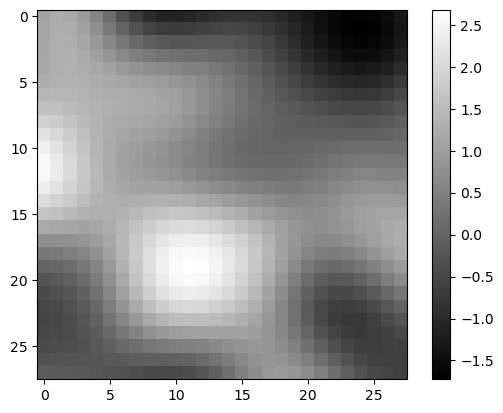

In [7]:
# np.random.seed(0)
grid_size=28
x = np.linspace(0, 1, grid_size)
y = np.linspace(0, 1, grid_size)
X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T

kernel = RBF(length_scale=0.2)
gp = GaussianProcessRegressor(kernel=kernel, random_state=300)
intensity = gp.sample_y(coords, n_samples=1, random_state=300).reshape(grid_size, grid_size)

# Add Gaussian noise
range_effects = np.ptp(intensity)
a_U = np.random.normal(0, range_effects / 20, size=intensity.shape)
intensity += a_U
original_image_snr1 = intensity - a_U

    
plt.imshow(original_image_snr1, cmap="gray")
plt.colorbar()
plt.show()

In [70]:
intensity.shape

(28, 28)

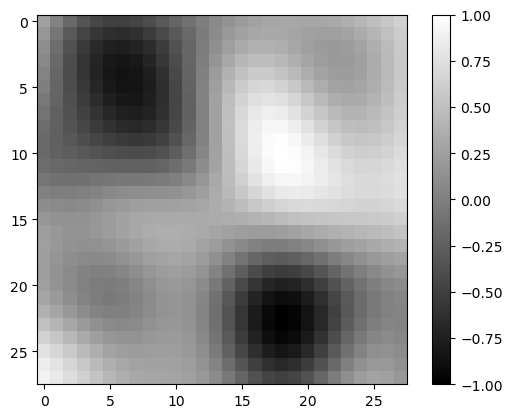

In [4]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Define image size (e.g., 28x28 for MNIST-like images)
image_size = 28
x = np.linspace(0, 1, image_size)
y = np.linspace(0, 1, image_size)
X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T  # Coordinates for each pixel

# Define the kernel for smoothness
length_scale = 0.2  # Adjust for desired smoothness
kernel = RBF(length_scale=length_scale)

# Sample from a Gaussian Process
gp = GaussianProcessRegressor(kernel=kernel)
intensity_samples = gp.sample_y(coords, n_samples=1, random_state=0).reshape(image_size, image_size)

# Normalize intensity to [0, 255] for a grayscale image
# intensity_samples = 255 * (intensity_samples - intensity_samples.min()) / (intensity_samples.max() - intensity_samples.min())
intensity_samples = (intensity_samples - intensity_samples.min()) / (intensity_samples.max() - intensity_samples.min())
intensity_samples = 2 * intensity_samples - 1
# Visualize the simulated image
import matplotlib.pyplot as plt
plt.imshow(intensity_samples, cmap="gray")
plt.colorbar()
plt.show()

In [4]:
### Start from here

import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm


In [5]:
N = [100, 500, 1000] # sample sizes: 100, 500, 1000
D = ['Poisson', 'Homo_Gamma', 'Hetero_Gaussian'] # true distribution

We consider the following generic semi-structured predictor $\eta_k$:

$$\eta_k = \beta_k + \alpha_{k,1} X_1 + \alpha_{k,2} X_2 + f_{k,1}(Z_1) + f_{k,2}(Z_2) + \text{d}(U),$$

where:
- $\tilde{X}_1, \tilde{X}_2 \sim \mathcal{N}(0, 1)$ are structured covariates for linear effects, and $\tilde{\alpha}_{1,1}, \tilde{\alpha}_{1,2}, \tilde{\alpha}_{2,1}$ and $\tilde{\alpha}_{2,2}$ are set to be 3, -1, -0.5 and 6 respectively. $X_1$ and $X_2$ are scaled from $\tilde{X}_1$ and $\tilde{X}_2$ into the range of $[0,1]$. Moreover, the linear effects for $\eta_k$ are scaled from $\sum_{i=1}^{2} \tilde{\alpha}_{k,i}\tilde{X}_i$ into $\sum_{i=1}^{2} \alpha_{k,i}X_i$ so that the scale of all effects is within the same range $[-1,1]$.

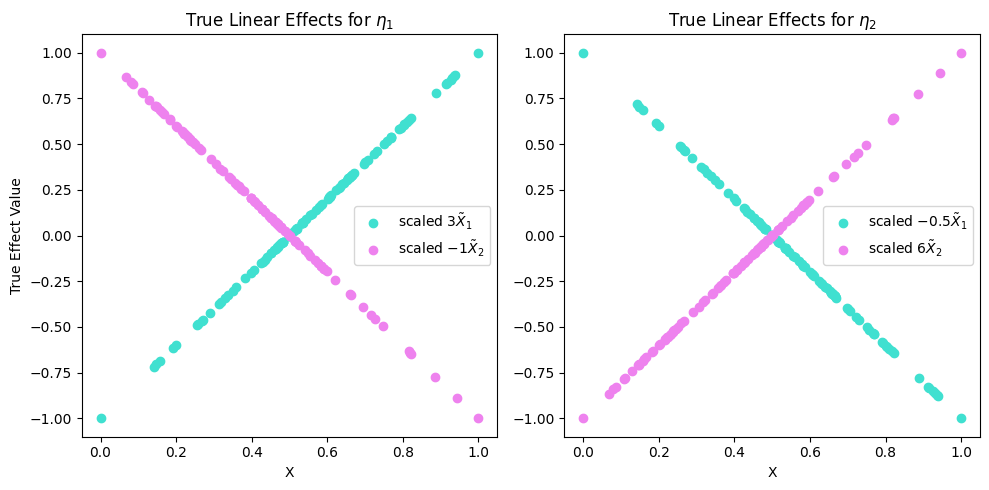

In [6]:

# 1. Structured Linear Effects
n = N[0]  # Adjust as needed
np.random.seed(42)
X1 = np.random.normal(0, 1, n)
X2 = np.random.normal(0, 1, n)
X1_scaled = (X1-min(X1))/(max(X1)-min(X1))
X2_scaled = (X2-min(X2))/(max(X2)-min(X2))


alpha_11, alpha_12, alpha_21, alpha_22 = 3, -1, -0.5, 6
linear_effect_11 = alpha_11 * X1_scaled
linear_effect_12 = alpha_12 * X2_scaled
linear_effect_21 = alpha_21 * X1_scaled
linear_effect_22 = alpha_22 * X2_scaled
linear_effect_11_scaled = 2 * (linear_effect_11-min(linear_effect_11))/(max(linear_effect_11)-min(linear_effect_11)) - 1
linear_effect_12_scaled = 2 * (linear_effect_12-min(linear_effect_12))/(max(linear_effect_12)-min(linear_effect_12)) - 1
linear_effect_21_scaled = 2 * (linear_effect_21-min(linear_effect_21))/(max(linear_effect_21)-min(linear_effect_21)) - 1
linear_effect_22_scaled = 2 * (linear_effect_22-min(linear_effect_22))/(max(linear_effect_22)-min(linear_effect_22)) - 1

# Plot linear effect
# plt.figure(figsize=(10, 6))
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(X1_scaled, linear_effect_11_scaled, 'o', label='scaled $3 \\tilde{X}_1$', color="turquoise")
ax1.plot(X2_scaled, linear_effect_12_scaled, 'o', label='scaled $-1 \\tilde{X}_2$', color="violet")
ax1.set_title("True Linear Effects for $\\eta_1$")
ax1.set_xlabel("X")
ax1.set_ylabel("True Effect Value")
ax1.legend()

ax2.plot(X1_scaled, linear_effect_21_scaled, 'o', label='scaled $-0.5 \\tilde{X}_1$', color="turquoise")
ax2.plot(X2_scaled, linear_effect_22_scaled, 'o', label='scaled $6 \\tilde{X}_2$', color="violet")
ax2.set_title("True Linear Effects for $\\eta_2$")
ax2.set_xlabel("X")
# ax2.set_ylabel("True Effect Value")
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()


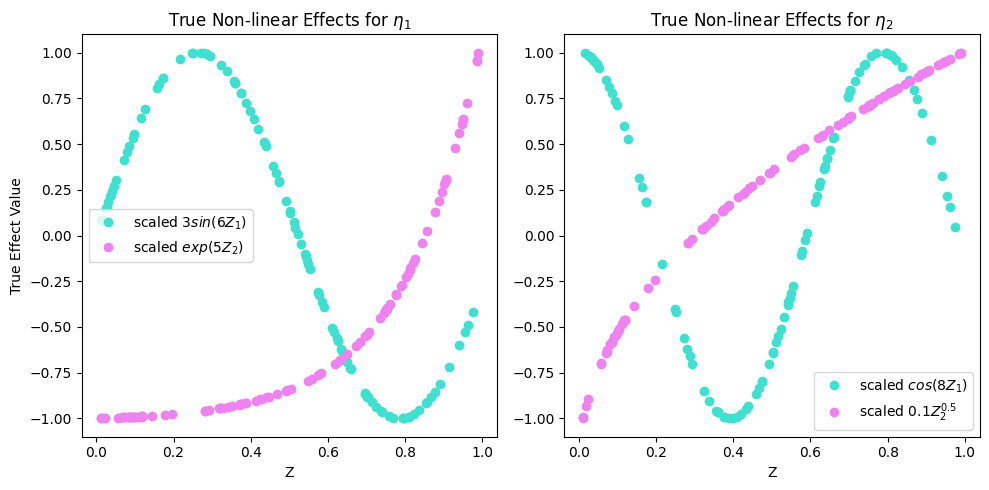

In [7]:

# 2. Structured Non-linear Effects
Z1 = np.random.uniform(0, 1, n)
Z2 = np.random.uniform(0, 1, n)

nonlinear_effect_11 = 3 * np.sin(6 * Z1)
nonlinear_effect_12 = np.exp(5 * Z2)
nonlinear_effect_21 = np.cos(8 * Z1)
nonlinear_effect_22 = 0.1*Z2**0.5
nonlinear_effect_11_scaled = 2 * (nonlinear_effect_11-min(nonlinear_effect_11))/(max(nonlinear_effect_11)-min(nonlinear_effect_11)) - 1
nonlinear_effect_12_scaled = 2 * (nonlinear_effect_12-min(nonlinear_effect_12))/(max(nonlinear_effect_12)-min(nonlinear_effect_12)) - 1
nonlinear_effect_21_scaled = 2 * (nonlinear_effect_21-min(nonlinear_effect_21))/(max(nonlinear_effect_21)-min(nonlinear_effect_21)) - 1
nonlinear_effect_22_scaled = 2 * (nonlinear_effect_22-min(nonlinear_effect_22))/(max(nonlinear_effect_22)-min(nonlinear_effect_22)) - 1

# Plot non-linear effects
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(Z1, nonlinear_effect_11_scaled, 'o', label='scaled $3 sin(6 Z_1)$', color="turquoise")
ax1.plot(Z2, nonlinear_effect_12_scaled, 'o', label='scaled $exp(5 Z_2)$', color="violet")
ax1.set_title("True Non-linear Effects for $\\eta_1$")
ax1.set_xlabel("Z")
ax1.set_ylabel("True Effect Value")
ax1.legend()

ax2.plot(Z1, nonlinear_effect_21_scaled, 'o', label='scaled $cos(8 Z_1)$', color="turquoise")
ax2.plot(Z2, nonlinear_effect_22_scaled, 'o', label='scaled $0.1 Z_2^{0.5}$', color="violet")
ax2.set_title("True Non-linear Effects for $\\eta_2$")
ax2.set_xlabel("Z")
# ax2.set_ylabel("True Effect Value")
ax2.legend()

# Display the plots
plt.tight_layout()
plt.show()


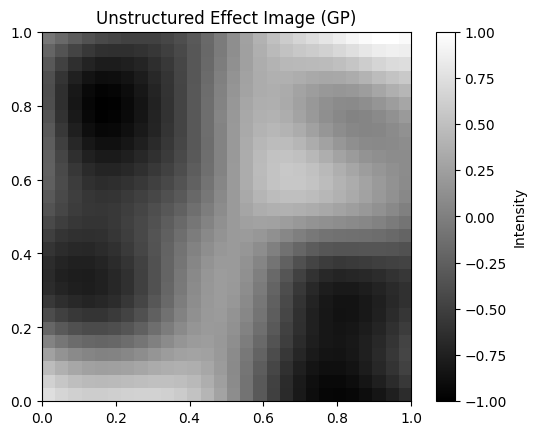

In [8]:

# 3. Unstructured Effect (Image using GP)
image_size = 28
x = np.linspace(0, 1, image_size)
y = np.linspace(0, 1, image_size)
X, Y = np.meshgrid(x, y)
coords = np.vstack([X.ravel(), Y.ravel()]).T

# Define the GP kernel and create a GP
length_scale = 0.2
kernel = RBF(length_scale=length_scale)
gp = GaussianProcessRegressor(kernel=kernel)

# Sample intensity values from the GP
intensity_samples = gp.sample_y(coords, n_samples=1, random_state=0).reshape(image_size, image_size)

# Scale to [-1,1]
intensity_samples = 2 * (intensity_samples - intensity_samples.min()) / (intensity_samples.max() - intensity_samples.min()) - 1

# Plot unstructured effect (GP image)
plt.figure()
plt.imshow(intensity_samples, cmap="gray", extent=(0, 1, 0, 1))
plt.colorbar(label="Intensity")
plt.title("Unstructured Effect Image (GP)")
plt.show()


In [9]:
# import numpy as np
# import noise  # Install with `pip install noise`
# import matplotlib.pyplot as plt

# def generate_perlin_image(size=28, octaves=4, persistence=0.5, lacunarity=2.0):
#     image = np.zeros((size, size))
#     scale = 5.0  # Controls the "zoom" level of the noise

#     # Normalize coordinates to [0, 1]
#     for i in range(size):
#         for j in range(size):
#             x, y = i / (size - 1), j / (size - 1)  # Normalized to [0, 1]
#             image[i][j] = noise.pnoise2(x * scale, y * scale, octaves=octaves, persistence=persistence, lacunarity=lacunarity, repeatx=size, repeaty=size, base=42)
    
#     # Normalize the image values to [-1, 1] range
#     image = 2 * (image - np.min(image)) / (np.max(image) - np.min(image)) - 1
#     return image

# # Generate and display the image
# perlin_image = generate_perlin_image()
# plt.imshow(perlin_image, cmap='gray', extent=[0, 1, 0, 1])
# plt.colorbar()
# plt.title("Simulated Image Using Perlin Noise with Normalized Coordinates")
# plt.xlabel("Normalized X (0 to 1)")
# plt.ylabel("Normalized Y (0 to 1)")
# plt.show()

In [10]:

# 4. Coverage Rate Calculation Example (for linear effect alpha_1)
# Assuming alpha_hat and its CI for each replication are obtained through some estimation method

# Placeholder example data
R = 100  # Number of replications
true_alpha_1 = 3
alpha_hat_samples = np.random.normal(loc=true_alpha_1, scale=0.5, size=R)  # Simulated estimated alpha values
alpha_CI_low = alpha_hat_samples - 1.96 * 0.5  # 95% CI lower bound
alpha_CI_high = alpha_hat_samples + 1.96 * 0.5  # 95% CI upper bound

# Compute coverage rate
coverage_rate_alpha_1 = np.mean((true_alpha_1 >= alpha_CI_low) & (true_alpha_1 <= alpha_CI_high))
print(f"Coverage Rate for Linear Effect α₁: {coverage_rate_alpha_1:.2f}")

# Repeat similar coverage rate calculations for other effects based on their respective confidence intervals

Coverage Rate for Linear Effect α₁: 0.93


Parallel Simulation for Coverage Rate Computation

In [2]:
!pip install ..

Processing /hkfs/home/haicore/scc/pa6512/PySSDR
  Preparing metadata (setup.py) ... done
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached typing_extensions-4.12.2-py3-none-any.whl.metadata (3.0 kB)
Using cached patsy-1.0.1-py2.py3-none-any.whl (232 kB)
Using cached numpy-1.24.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 107.1 MB/s eta 0:00:00
Using cached typing_extensions-4.12.2-py3-none-any.whl (37 kB)
  Created wheel for PySddr: filename=PySddr-0.11.dev0-py3-none-any.whl size=34911 sha256=f2ef3cd682c565bd52de7fb883e3348fbf0ff13db895e82d9e5aa1a3a32ff1da
  Stored in directory: /scratch/pip-ephem-wheel-cache-sos28qq_/wheels/89/08/40/4e93508f24eb93ffd988f08e8e9af6db57057e7baeb3f7bfbf
Successfully bu

In [7]:
!hostname # Verify the Host

Dingyis-MacBook-Pro.local


In [1]:
!nvidia-smi


Mon Dec 23 11:22:39 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:CA:00.0 Off |                   On |
| N/A   43C    P0             49W /  400W |      87MiB /  40960MiB |     N/A      Default |
|                                         |                        |              Enabled |
+-----------------------------------------+-----

In [15]:
!kill -9 658088

/bin/bash: line 0: kill: (658088) - No such process


In [16]:
!squeue -u $USER  # SLURM example # This will display your active jobs and the allocated nodes.


             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1489148    normal jupyterh   pa6512  R    1:41:03      1 haicn1701


In [1]:
import psutil

# Get total physical/logical CPU cores
print(f"Logical CPU cores available: {psutil.cpu_count(logical=True)}")
print(f"Physical CPU cores available: {psutil.cpu_count(logical=False)}")

# Check current CPU usage per core
cpu_usage = psutil.cpu_percent(percpu=True)
print(f"CPU usage per core: {cpu_usage}")


Logical CPU cores available: 152
Physical CPU cores available: 76
CPU usage per core: [2.5, 1.0, 4.0, 1.2, 0.5, 0.9, 9.3, 0.1, 4.9, 0.1, 0.2, 0.2, 0.2, 0.0, 0.9, 0.4, 1.2, 0.0, 0.1, 0.0, 0.1, 0.1, 0.0, 0.0, 0.1, 0.1, 0.1, 0.3, 3.4, 0.8, 0.3, 0.0, 0.0, 0.1, 0.5, 0.7, 0.9, 0.7, 11.1, 0.3, 1.2, 0.3, 0.1, 1.7, 0.7, 1.1, 0.1, 0.0, 0.1, 0.2, 0.0, 0.0, 0.1, 0.0, 0.4, 0.0, 0.1, 1.3, 0.0, 0.0, 1.4, 0.1, 0.1, 0.1, 0.5, 0.0, 0.0, 0.1, 1.3, 0.3, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 10.8, 1.8, 0.2, 0.0, 0.2, 0.1, 0.8, 0.0, 0.0, 0.0, 0.0, 0.0, 13.8, 0.0, 13.8, 0.0, 0.2, 0.5, 0.2, 0.1, 0.0, 0.2, 0.0, 0.7, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.7, 0.0, 4.5, 17.6, 0.0, 0.0, 0.0, 0.2, 0.1, 0.2, 0.1, 0.1, 0.0, 0.6, 0.2, 0.3, 0.4, 0.0, 0.8, 0.0, 0.0, 0.0, 0.0, 0.4, 0.2, 1.7, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.1, 0.0]


In [2]:
import multiprocessing as mp
import logging
from worker import f 

def f(x):
    return g(x)*x

def g(x):
    return x*x

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)

    # Use a smaller pool size for debugging or scale based on CPU cores
    with mp.Pool(4) as pool:  # Adjust the pool size if necessary
        results = pool.map(f, [1, 2, 3, 4])
        
        # Simulating 'scenarios' length to avoid KeyError
        scenarios = [1, 2, 3, 4]

        for i, result in enumerate(results):
            logging.info(f"Completed {i+1}/{len(scenarios)} datasets.")


INFO:root:Completed 1/4 datasets.
INFO:root:Completed 2/4 datasets.
INFO:root:Completed 3/4 datasets.
INFO:root:Completed 4/4 datasets.


In [27]:
import multiprocessing as mp
import logging


class Worker:
    def __init__(self, a):
        self.a = a

    @staticmethod
    def f(xy, a):
        x, y = xy
        return x * y + a  # Simple operation

if __name__ == "__main__":
    logging.basicConfig(level=logging.INFO)
    a_value = 6
    
    with mp.Pool(4) as pool:  # 4 parallel processes
        results = pool.starmap(Worker.f, [((1, 1), a_value), ((2, 3), a_value), ((3, 5), a_value), ((4, 6), a_value)])
        for i, result in enumerate(results):
            logging.info(f"Completed task {i+1} | Result: {result}")


INFO:root:Completed task 1 | Result: 7
INFO:root:Completed task 2 | Result: 12
INFO:root:Completed task 3 | Result: 21
INFO:root:Completed task 4 | Result: 30


In [18]:
# Ensure TensorFlow uses GPU
print(tf.config.list_physical_devices('GPU'))


print("Is CUDA available?", torch.cuda.is_available())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Is CUDA available? True


In [10]:

def dummy_function(i):
    return i**2

# Parallel execution
start_parallel = time()
with mp.Pool(processes=4) as pool:  # Replace 4 with the number of allocated cores
    results = pool.map(dummy_function, range(1000000))
print("Parallel Execution Time:", time() - start_parallel)

# Sequential execution
start_sequential = time()
results_seq = [dummy_function(i) for i in range(1000000)]
print("Sequential Execution Time:", time() - start_sequential)

# meaning that the parallel execution is even much slower

Parallel Execution Time: 0.4867572784423828
Sequential Execution Time: 0.2705116271972656


In [20]:
import os
print("SLURM_NODELIST:", os.getenv("SLURM_NODELIST"))
print("SLURM_CPUS_ON_NODE:", os.getenv("SLURM_CPUS_ON_NODE"))
print("SLURM_JOB_CPUS_PER_NODE:", os.getenv("SLURM_JOB_CPUS_PER_NODE"))


SLURM_NODELIST: haicn1701
SLURM_CPUS_ON_NODE: 2
SLURM_JOB_CPUS_PER_NODE: 2


In [21]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [26]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())

CUDA available: True
Current device: 0


In [25]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [7]:
import multiprocessing as mp

mp.set_start_method("spawn", force=True)

In [1]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch

In [8]:
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [10]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


2024-12-22 09:16:41.091932: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-12-22 09:16:41.091974: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: haicn1701.localdomain
2024-12-22 09:16:41.091982: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: haicn1701.localdomain
2024-12-22 09:16:41.092083: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.54.15
2024-12-22 09:16:41.092103: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.54.15
2024-12-22 09:16:41.092107: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.54.15


In [11]:
with tf.device('/CPU:0'):
    # Any TensorFlow operations here will run on CPU
    print(tf.reduce_sum(tf.random.normal([1000, 1000])))


tf.Tensor(-15.288513, shape=(), dtype=float32)


In [ ]:

# def train_ssdr(X_struct, Z_struct, images, y, formulas, deep_models_dict, distribution='Poisson', epochs=75, batch_size=128, learning_rate=0.01, verbose=0):
#     # Instantiate the SSDR model class
#     sddr_model = Sddr(config={
#         'train_parameters': {
#             'epochs': epochs,
#             'batch_size': batch_size,
#             'learning_rate': learning_rate,
#             'val_split': 0.2,
#             'optimizer': optim.Adam,
#             'early_stop_epsilon': 0.001,
#             'dropout_rate': 0.01
#         },
#         'formulas': formulas,
#         'distribution': distribution,
#         'deep_models_dict': deep_models_dict,  # Placeholder, modify as necessary
#         'output_dir': './results'
#     })
    
#     # Train the model using the structured and unstructured data
#     sddr_model.train(target=y, structured_data=X_struct, unstructured_data={'image': images}, resume=False)
    
#     return sddr_model


# # Worker function for parallel simulation
# def simulate_single_study(args):
#     n_samples, K, I, J, grid_size, alpha, beta, random_state = args
#     # Load the model from file
#     dnn_model = tf.keras.models.load_model("dnn_model.h5")
#     X, Z, images, etas = generate_dataset(
#         n_samples=n_samples,
#         K=K,
#         I=I,
#         J=J,
#         grid_size=grid_size,
#         alpha=alpha,
#         beta=beta,
#         dnn_model=dnn_model,
#         random_state=random_state
#     )
#     y = simulate_response(etas, distribution="poisson")
#     model = train_ssdr(X, images, y, epochs=50, batch_size=32, learning_rate=0.01, verbose=0)
#     return model

# # Parallel execution
# def parallel_simulation(settings, n_cores=4):
#     with mp.Pool(n_cores) as pool:
#         results = pool.map(simulate_single_study, settings)
#     return results

# # Train models in parallel
# trained_models = parallel_train_models(
#     datasets=[(X, images, y) for (X, _, images, _, y) in zip(datasets, responses)],
#     n_cores=4,
#     epochs=75,
#     batch_size=128,
#     learning_rate=0.01,
#     verbose=0
# )

# # print("Simulation completed. Trained models:", len(trained_models))
# # Example settings
# settings = [
#     (10, 1, 2, 2, 28, alpha, beta, seed) for seed in range(4)
# ]

# results = parallel_simulation(settings)
# # ---------------------------
# # Example Usage
# # ---------------------------

# # Example coefficients for linear and nonlinear effects
# alpha = {1: [3, -1], 2: [-0.5, 6]}
# beta = {
#     1: [lambda Z1: scale_to_range(3 * np.sin(6 * Z1)), lambda Z2: scale_to_range(np.exp(5 * Z2))],
#     2: [lambda Z1: scale_to_range(np.cos(8 * Z1)), lambda Z2: scale_to_range(0.1 * np.sqrt(Z2))]
# }

# # Define and train a DNN model
# grid_size = 28
# dnn_model = build_dnn(grid_size * grid_size)  # Pre-trained DNN
# # Optionally, train or load pre-trained weights
# # dnn_model.load_weights("path_to_trained_dnn_model")


In [ ]:
# ---------------------------
# Parallel Helper Functions
# ---------------------------

def generate_and_train_single(args):
    """
    Generate dataset and train SSDR for a single scenario.
    Combines data generation and training for streamlined parallelization.
    """
    n_samples, K, I, J, grid_size, alpha, beta, dnn_model_path, random_state, distribution, save_path = args
    
    # Load pre-trained DNN model (shared across workers)
    dnn_model = tf.keras.models.load_model(dnn_model_path)
    
    # Generate dataset
    try:
        X, Z, images, etas = generate_dataset(
            n_samples=n_samples,
            K=K,
            I=I,
            J=J,
            grid_size=grid_size,
            alpha=alpha,
            beta=beta,
            dnn_model=dnn_model,
            random_state=random_state
        )
        # Simulate response
        y = simulate_response(etas, distribution=distribution, K=K)
        
        # Train SSDR model
        model = train_ssdr(X, images, y, epochs=50, batch_size=32, learning_rate=0.01, verbose=0)
        
        # Save trained model and outputs
        model.save(f"{save_path}/model_{random_state}.h5")
        np.savez_compressed(
            f"{save_path}/data_{random_state}.npz",
            X=X, Z=Z, images=images, etas=etas, y=y
        )
        
        return f"Success: Scenario {random_state}"
    except Exception as e:
        return f"Error: Scenario {random_state} failed with {str(e)}"

def parallel_simulation_and_training(
    scenarios, dnn_model_path, n_cores=4, save_path="./results", grid_size=28, alpha=None, beta=None
):
    """
    Run simulation and training in parallel for multiple scenarios.
    """
    # Create save directory if it doesn't exist
    os.makedirs(save_path, exist_ok=True)
    
    # Prepare arguments for each scenario
    args_list = [
        (
            n_samples, K, I, J, grid_size, alpha, beta,
            dnn_model_path, random_state, distribution, save_path
        )
        for n_samples, K, I, J, random_state, distribution in scenarios
    ]
    
    # Parallel execution
    with mp.Pool(n_cores) as pool:
        results = pool.map(generate_and_train_single, args_list)
    
    return results

# ---------------------------
# Example Simulation Setup
# ---------------------------

# Pre-trained DNN for unstructured effects
grid_size = 28
dnn_model = build_dnn(grid_size * grid_size)
dnn_model.save("dnn_model.h5")  # Save pre-trained DNN for worker usage

# Define simulation scenarios
scenarios = [
    (10, 2, 2, 2, i, "poisson") for i in range(10)
] + [
    (10, 2, 2, 2, i, "gamma") for i in range(10, 20)
] + [
    (10, 2, 2, 2, i, "gaussian") for i in range(20, 30)
]

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Run simulation and training
results = parallel_simulation_and_training(
    scenarios=scenarios,
    dnn_model_path="dnn_model.keras",
    n_cores=4,
    save_path="./results",
    grid_size=grid_size,
    alpha={1: [3, -1], 2: [-0.5, 6]},
    beta={
        1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
        2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
    }
)

# Print results
print("\n".join(results))


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Add, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from multiprocessing import Pool
import os



In [ ]:
# Ensure TensorFlow uses GPU
print(tf.config.list_physical_devices('GPU'))

import torch
print("Is CUDA available?", torch.cuda.is_available())

In [ ]:


import tensorflow as tf
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Add, Activation
from deepregression import deepregression, ensemble
from scipy.stats import norm

# Function to define the SSDR model
def build_ssdr_model(input_struct_dim, input_unstruct_dim, activation="relu"):
    # Structured Input
    input_struct = Input(shape=(input_struct_dim,))
    structured_head = Dense(1, use_bias=False, name="structured_head")(input_struct)
    
    # Unstructured Input
    input_unstruct = Input(shape=(input_unstruct_dim,))
    unstructured_net = tf.keras.Sequential([
        Dense(32, activation=activation),
        Dense(16, activation=activation),
        Dense(1, activation=None)
    ])
    unstructured_head = unstructured_net(input_unstruct)
    
    # Combined Predictor
    combined_output = Add()([structured_head, unstructured_head])
    combined_output = Activation("linear")(combined_output)
    
    model = Model(inputs=[input_struct, input_unstruct], outputs=combined_output)
    model.compile(optimizer="adam", loss="mse", metrics=["mae"])
    return model

# Helper function for dropout sampling
def dropout_sampling(model, structured_input, unstructured_input, num_samples=1000, p_dropout=0.2):
    dropout_outputs = []
    for _ in range(num_samples):
        dropout_output = model.predict(
            [structured_input, unstructured_input], training=True
        )
        dropout_outputs.append(dropout_output)
    
    # Compute mean and uncertainty
    dropout_outputs = np.array(dropout_outputs)
    mean = np.mean(dropout_outputs, axis=0)
    uncertainty = np.std(dropout_outputs, axis=0)
    return mean, uncertainty

# Function to implement last-layer inference
def last_layer_inference(model, structured_input, unstructured_input):
    # Extract penultimate layer outputs
    penultimate_layer = Model(
        inputs=model.input,
        outputs=model.get_layer("structured_head").output
    )
    structured_features = penultimate_layer.predict(structured_input)

    # Fit a simple regression model on extracted features
    from sklearn.linear_model import LinearRegression
    linreg = LinearRegression()
    linreg.fit(structured_features, unstructured_input)

    # Predict values and return uncertainty
    predictions = linreg.predict(structured_features)
    residuals = unstructured_input - predictions
    uncertainty = np.std(residuals)
    return predictions, uncertainty

# Core SSDR training and evaluation function
def train_ssdr(X_struct, X_unstruct, y, eval_data, method="deep_ensemble", 
               n_ensemble=5, p_dropout=0.2, num_samples=1000):
    """
    Train an SSDR model and perform uncertainty quantification.
    
    Args:
        X_struct (np.array): Structured covariates.
        X_unstruct (np.array): Unstructured covariates.
        y (np.array): Response variable.
        eval_data (tuple): Evaluation data as (X_struct_eval, X_unstruct_eval, y_eval).
        method (str): Evaluation method - "deep_ensemble", "dropout", or "last_layer".
        n_ensemble (int): Number of ensemble members for deep ensemble.
        p_dropout (float): Dropout rate for dropout sampling.
        num_samples (int): Number of Monte Carlo samples for dropout sampling.
        
    Returns:
        Results including predictions, uncertainties, and coverage rates.
    """
    X_struct_eval, X_unstruct_eval, y_eval = eval_data
    
    # Train base SSDR model
    model = build_ssdr_model(X_struct.shape[1], X_unstruct.shape[1])
    model.fit([X_struct, X_unstruct], y, epochs=50, batch_size=32, verbose=1)

    # Deep ensemble
    if method == "deep_ensemble":
        # Train ensemble of models
        ensemble_models = []
        for i in range(n_ensemble):
            ensemble_model = build_ssdr_model(X_struct.shape[1], X_unstruct.shape[1])
            ensemble_model.fit([X_struct, X_unstruct], y, epochs=50, verbose=0)
            ensemble_models.append(ensemble_model)
        
        # Predict and compute ensemble uncertainty
        ensemble_predictions = np.array([
            model.predict([X_struct_eval, X_unstruct_eval]) for model in ensemble_models
        ])
        mean_predictions = np.mean(ensemble_predictions, axis=0)
        uncertainty = np.std(ensemble_predictions, axis=0)
    
    # Dropout sampling
    elif method == "dropout":
        mean_predictions, uncertainty = dropout_sampling(
            model, X_struct_eval, X_unstruct_eval, num_samples, p_dropout
        )
    
    # Last-layer inference
    elif method == "last_layer":
        mean_predictions, uncertainty = last_layer_inference(
            model, X_struct_eval, X_unstruct_eval
        )
    
    else:
        raise ValueError("Unsupported method. Choose from 'deep_ensemble', 'dropout', or 'last_layer'.")
    
    # Calculate confidence intervals and coverage rates
    confidence_level = 0.95
    z = norm.ppf(1 - (1 - confidence_level) / 2)
    lower_bound = mean_predictions - z * uncertainty
    upper_bound = mean_predictions + z * uncertainty
    coverage_rate = np.mean((y_eval >= lower_bound) & (y_eval <= upper_bound))
    
    return {
        "mean_predictions": mean_predictions,
        "uncertainty": uncertainty,
        "coverage_rate": coverage_rate,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound
    }


# Training SSDR model: This includes DNN for unstructured part
def train_ssdr(X_struct, X_unstruct, y, epochs=75, batch_size=128, learning_rate=0.01):
    input_struct = Input(shape=(X_struct.shape[1],))
    input_unstruct = Input(shape=(X_unstruct.shape[1],))

    # Structured part (linear and smooth)
    structured_head = Dense(1, use_bias=False)(input_struct)
    
    # Unstructured part (DNN)
    unstructured_net = build_dnn(X_unstruct.shape[1])
    unstructured_head = unstructured_net(input_unstruct)

    # Combined output
    combined_output = Add()([structured_head, unstructured_head])
    combined_output = Activation('exponential')(combined_output)

    model = Model(inputs=[input_struct, input_unstruct], outputs=combined_output)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='poisson', metrics=['mae'])

    # Train model
    model.fit([X_struct, X_unstruct], y, epochs=epochs, batch_size=batch_size, verbose=0)
    return model

# Simulate response for different distributions
def simulate_response(eta, distribution="poisson"):
    if distribution == "poisson":
        return np.random.poisson(np.exp(eta))
    elif distribution == "gamma":
        scale = np.exp(eta)  # mean of the gamma
        return np.random.gamma(2.0, scale / 2.0)  # shape = mean^2 / variance
    elif distribution == "gaussian":
        mu = eta
        sigma = np.abs(eta) / 2  # heteroscedastic variance
        return np.random.normal(mu, sigma)

# Example coefficients for linear and nonlinear effects
alpha = {1: [3, -1], 2: [-0.5, 6]}
beta = {
    1: [lambda Z1: scale_to_range(3 * np.sin(6 * Z1)), lambda Z2: scale_to_range(np.exp(5 * Z2))],
    2: [lambda Z1: scale_to_range(np.cos(8 * Z1)), lambda Z2: scale_to_range(0.1 * np.sqrt(Z2))]
}

# Example usage:
n_samples = 1000
grid_size = 28
dnn_model = build_dnn(grid_size * grid_size)  # Pre-trained DNN
# dnn_model.load_weights("path_to_trained_dnn_model")  # Load weights if available

X, Z, images, eta, unstructured_effects = generate_dataset(
    n_samples, K=2, I=2, J=2, grid_size=28, alpha=alpha, beta=beta, dnn_model=dnn_model
)



# Train SSDR model using structured and unstructured data
y = simulate_response(eta, distribution="poisson")  # Use eta to generate responses
model = train_ssdr(X_struct, images, y)

# Model is now trained and can be used for further analysis.

In [ ]:
import os
# Change to the desired directory
# os.chdir('/hkfs/home/haicore/scc/pa6512/PySSDR/')

print(os.getcwd())

In [ ]:
dnn_model = tf.keras.models.load_model("dnn_model.h5")

In [ ]:
import os
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
from multiprocessing import Pool
from tensorflow.keras.models import load_model
from torch.utils.data import DataLoader, random_split

# Helper function to scale data to the range [-1, 1]
def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower


# Generate the structured linear effects
def generate_linear_effects(n_samples, K=2, I=2, alpha=None, random_state=42):
    np.random.seed(random_state)
    X = np.random.normal(size=(n_samples, I))
    X_scaled = scale_to_range(X)
    
    if alpha is None:
        raise ValueError("Alpha coefficients for linear effects must be provided.")
    
    linear_effects = np.zeros((n_samples, K))
    for k in range(1, K + 1):
        for i in range(I):
            linear_effects[:, k - 1] += alpha[k][i] * X_scaled[:, i]
    
    return X_scaled, linear_effects


# Generate unstructured effects via the fixed DNN
def generate_unstructured_effects(images, dnn_model, K=2):
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))
    for k in range(K):
        unstructured_output = dnn_model.predict(images.reshape(n_samples, -1)).flatten()
        unstructured_effects[:, k] = scale_to_range(unstructured_output)
    return unstructured_effects


# Generate dataset
def generate_dataset(n_samples, K=2, I=2, J=2, grid_size=28, alpha=None, beta=None, dnn_model=None, random_state=None):
    X, linear_effects = generate_linear_effects(n_samples, K, I, alpha, random_state)
    Z = np.random.uniform(0, 1, size=(n_samples, J))
    nonlinear_effects = np.zeros((n_samples, K))
    
    if dnn_model is None:
        raise ValueError("A pre-trained DNN model must be provided for generating unstructured effects.")
    
    unstructured_effects = generate_unstructured_effects(np.random.rand(n_samples, grid_size, grid_size), dnn_model, K)

    intercepts = [1.0, 2.0]
    etas = np.zeros((n_samples, K))
    for k in range(K):
        etas[:, k] = intercepts[k] + linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
    
    return X, Z, np.random.rand(n_samples, grid_size, grid_size), etas


# Simulate response
def simulate_response(etas, distribution="poisson", K=2):
    n_samples = etas.shape[0]
    if distribution == "poisson" and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma" and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples)
    elif distribution == "gaussian" and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError("Unsupported distribution or incorrect K value.")


# Parallel dataset generation function
def generate_single_dataset(args):
    n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state = args
    return generate_dataset(n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state)


# Parallelize dataset generation
def parallel_generate_datasets(scenarios, dnn_model, n_cores=4, grid_size=28, alpha=None, beta=None):
    args_list = [(n_samples, K, I, J, grid_size, alpha, beta, dnn_model, random_state)
                 for n_samples, K, I, J, random_state in scenarios]
    
    with Pool(n_cores) as pool:
        results = pool.map(generate_single_dataset, args_list)
    return results


# Train SSDR model
def train_ssdr(X_struct, Z_struct, images, y, epochs=75, batch_size=128, learning_rate=0.01, verbose=0):
    # Instantiate the SSDR model class
    sddr_model = Sddr(config={
        'train_parameters': {
            'epochs': epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'val_split': 0.2
        },
        'formulas': ['loc ~ 1 + x1 + s(xa)', 'scale ~ 1'],
        'distribution': 'gaussian',
        'deep_models_dict': {'loc': 'dnn_model_path'},  # Placeholder, modify as necessary
        'output_dir': './output'
    })
    
    # Train the model using the structured and unstructured data
    sddr_model.train(target=y, structured_data=X_struct, unstructured_data={'image': images}, resume=False)
    
    return sddr_model


# Parallel execution of SSDR training
def parallel_train_models(datasets, n_cores=4, epochs=75, batch_size=128, learning_rate=0.01, verbose=0):
    def train_single_model(args):
        X, images, y, epochs, batch_size, learning_rate, verbose = args
        return train_ssdr(X, images, y, epochs, batch_size, learning_rate, verbose)
    
    train_args = [
        (X, images, y, epochs, batch_size, learning_rate, verbose)
        for X, _, images, _, y in datasets
    ]
    
    with Pool(n_cores) as pool:
        results = pool.map(train_single_model, train_args)
    return results


# Simulation Setup
def parallel_simulation(settings, dnn_model, n_cores=4):
    with Pool(n_cores) as pool:
        results = pool.map(simulate_single_study, settings)
    return results


# Example usage of the parallel dataset generation and model training
def main():
    # Pre-trained DNN for unstructured effects (image-based)
    grid_size = 28
    dnn_model = load_model("dnn_model.h5")  # Assume model is pre-trained and saved
    
    # Coefficients for structured effects (linear + nonlinear)
    alpha = {1: [3, -1], 2: [-0.5, 6]}
    beta = {
        1: [lambda Z1: scale_to_range(3 * np.sin(6 * Z1)), lambda Z2: scale_to_range(np.exp(5 * Z2))],
        2: [lambda Z1: scale_to_range(np.cos(8 * Z1)), lambda Z2: scale_to_range(0.1 * np.sqrt(Z2))]
    }

    # Define simulation scenarios (example: 5 simulations with different random seeds)
    scenarios = [
        (5, 2, 2, 2, grid_size, alpha, beta, dnn_model, i) for i in range(5)
    ]
    
    # Generate datasets in parallel
    datasets = parallel_generate_datasets(scenarios, dnn_model, n_cores=4, grid_size=grid_size, alpha=alpha, beta=beta)

    # Simulate responses for each dataset
    responses = [simulate_response(eta, distribution="poisson", K=2) for _, _, _, eta in datasets]

    # Train models in parallel
    trained_models = []
    for i, dataset in enumerate(datasets):
        X, Z, images, eta = dataset
        y = responses[i]
        model = train_ssdr(X, Z, images, y, epochs=50, batch_size=32, learning_rate=0.01, verbose=0)
        trained_models.append(model)

    print("Simulation completed. Trained models:", len(trained_models))

if __name__ == "__main__":
    main()


In [41]:
import psutil

# Get total physical/logical CPU cores
print(f"Logical CPU cores available: {psutil.cpu_count(logical=True)}")
print(f"Physical CPU cores available: {psutil.cpu_count(logical=False)}")

# Check current CPU usage per core
cpu_usage = psutil.cpu_percent(percpu=True)
print(f"CPU usage per core: {cpu_usage}")


Logical CPU cores available: 152
Physical CPU cores available: 76
CPU usage per core: [16.1, 0.8, 22.2, 0.9, 0.9, 0.6, 0.4, 0.3, 0.3, 0.8, 0.3, 0.1, 0.1, 0.2, 0.2, 0.4, 8.7, 0.4, 0.4, 19.8, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.1, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 15.6, 0.5, 2.0, 0.2, 0.1, 0.5, 0.0, 0.3, 0.4, 0.6, 0.3, 0.3, 0.1, 0.1, 0.1, 0.4, 0.7, 0.2, 0.0, 15.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import tensorflow as tf

from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Flatten, ReLU
# import torch.optim as optim

from time import time
from scipy.stats import poisson, gamma, norm
import multiprocessing as mp
# from sddr import Sddr  # Assuming you have pyssdr installed and configured correctly
import logging
from datetime import datetime
# import torch
logging.basicConfig(level=logging.INFO)
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


# ---------------------------
# Helper Functions
# ---------------------------

def scale_to_range(data, lower=-1, upper=1):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * (upper - lower) + lower

def build_dnn(input_dim, layer_sizes=[32, 16], activation="relu"):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(layer_sizes[0], activation=activation),
        Dense(layer_sizes[1], activation=activation),
        Dense(1, activation=None)
    ])
    return model

def generate_gp_image(grid_size=28, length_scale=0.2, random_state=None):
    np.random.seed(random_state)
    x = np.linspace(0, 1, grid_size)
    y = np.linspace(0, 1, grid_size)
    X, Y = np.meshgrid(x, y)
    coords = np.vstack([X.ravel(), Y.ravel()]).T

    kernel = RBF(length_scale=length_scale)
    gp = GaussianProcessRegressor(kernel=kernel)
    intensity = gp.sample_y(coords, n_samples=1).reshape(grid_size, grid_size)
    return scale_to_range(intensity)

# ---------------------------
# Simulation Functions
# ---------------------------

def generate_linear_effects(n_samples, K, I, alpha, random_state=None):
    np.random.seed(random_state)
    X = np.random.normal(size=(n_samples, I))
    X_scaled = scale_to_range(X, 0, 1)
    linear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for i in range(I):
            linear_effects[:, k - 1] += alpha[k][i] * X_scaled[:, i]
    return X_scaled, scale_to_range(linear_effects)

def generate_nonlinear_effects(n_samples, K, J, beta, random_state=None):
    np.random.seed(random_state)
    Z = np.random.uniform(0, 1, size=(n_samples, J))
    nonlinear_effects = np.zeros((n_samples, K))

    for k in range(1, K + 1):
        for j in range(J):
            nonlinear_effects[:, k - 1] += beta[k][j](Z[:, j])
    return Z, scale_to_range(nonlinear_effects)

def generate_unstructured_effects(images, dnn_model, K):
    n_samples = len(images)
    unstructured_effects = np.zeros((n_samples, K))

    for k in range(K):
        unstructured_output = np.random.rand(n_samples)  # Mock prediction
        unstructured_effects[:, k] = scale_to_range(unstructured_output)
    return unstructured_effects

def combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR):
    K = linear_effects.shape[1]
    etas = np.zeros((X.shape[0], K))

    for k in range(K):
        etas[:, k] = linear_effects[:, k] + nonlinear_effects[:, k] + unstructured_effects[:, k]
        std_eta = np.std(etas[:, k])
        intercept = (std_eta * SNR + np.min(etas[:, k]) - np.max(etas[:, k]))
        etas[:, k] += intercept
    return etas

def simulate_response(etas, distribution="poisson", K=2):
    n_samples = etas.shape[0]

    if distribution == "poisson" and K == 1:
        mu = np.exp(etas[:, 0])
        return np.random.poisson(mu)
    elif distribution == "gamma" and K == 2:
        mu = np.exp(etas[:, 0])
        sigma = 1.0
        shape = (mu / sigma) ** 2
        scale = sigma ** 2 / mu
        return np.random.gamma(shape, scale, n_samples)
    elif distribution == "gaussian" and K == 2:
        mu = etas[:, 0]
        sigma = np.exp(etas[:, 1])
        return np.random.normal(mu, sigma, n_samples)
    else:
        raise ValueError(f"Unsupported distribution: {distribution}")

def save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path):
    os.makedirs(save_path, exist_ok=True)
    scenario_index = '_'.join(map(str, scenario))
    np.save(f"{save_path}/X_{scenario_index}_rep{rep}.npy", X)
    np.save(f"{save_path}/Z_{scenario_index}_rep{rep}.npy", Z)
    np.save(f"{save_path}/images_{scenario_index}_rep{rep}.npy", images)
    np.save(f"{save_path}/etas_{scenario_index}_rep{rep}.npy", etas)
    np.save(f"{save_path}/responses_{scenario_index}_rep{rep}.npy", responses)
    logging.info(f"Saved dataset {scenario_index}_rep{rep} and responses.")

# ---------------------------
# Generate Task Function for Parallel Execution
# ---------------------------

def generate_task(task_index, scenario_index, rep, scenarios, alpha, beta, grid_size, save_path):
    scenario = scenarios[scenario_index]
    n_samples, distribution, K, SNR = scenario
    
    # Build the DNN model (mock)
    dnn_model = build_dnn(grid_size * grid_size)

    logging.info(f"Generating dataset: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate structured and unstructured effects
    X, linear_effects = generate_linear_effects(n_samples, K, 2, alpha, random_state=task_index)
    Z, nonlinear_effects = generate_nonlinear_effects(n_samples, K, 2, beta, random_state=task_index)
    images = np.array([generate_gp_image(grid_size, random_state=task_index * 5000 + i) for i in range(n_samples)])
    unstructured_effects = generate_unstructured_effects(images, dnn_model, K)
    logging.info(f"Generated X, Z, images and unstructured_effects: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    etas = combine_effects(X, Z, unstructured_effects, linear_effects, nonlinear_effects, SNR)
    logging.info(f"Generated etas: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Generate response based on distribution
    responses = simulate_response(etas, distribution, K)
    logging.info(f"Generated responses: Scenario {scenario_index} | Replication {rep} | {scenario}")
    
    # Save datasets and responses
    save_results(scenario, rep, n_samples, X, Z, images, etas, responses, save_path)

# ---------------------------
# Parallel Execution Function
# ---------------------------

# def parallel_generate(scenarios, grid_size, alpha, beta, n_cores=None, n_rep=4, save_path="output/"):
#     logging.info("Starting parallel dataset generation...")
#     start_time = datetime.now()
    
#     # Create (scenario_index, rep) combinations for parallel processing
#     task_list = [(i, r) for i in range(len(scenarios)) for r in range(n_rep)]
#     print(task_list)
#     # Ensure n_cores is set if not provided
#     if n_cores is None:
#         n_cores = n_rep * len(scenarios)
#     logging.info(f"number of cores used: {n_cores}.")
    
#     # Use pool.starmap to pass multiple arguments to the method
#     with mp.Pool(n_cores) as pool:
#         pool.starmap(generate_task, [(task_index, idx, r, scenarios, alpha, beta, grid_size, save_path) 
#                                      for idx, (task_index, r) in enumerate(task_list)])
    
#     end_time = datetime.now()
#     logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")

def parallel_generate(scenarios, grid_size, alpha, beta, n_cores=None, total_reps=100, reps_per_chunk=10, save_path="output/"):
    logging.info("Starting parallel dataset generation...")
    start_time = datetime.now()

    # Generate (scenario_index, rep) combinations
    task_list = []
    task_index = 0  # Initialize task index
    
    for scenario_index in range(len(scenarios)):
        for rep in range(total_reps):
            task_list.append((task_index, scenario_index, rep))
            task_index += 1  # Increment task index

    # Split task_list into chunks
    chunk_count = len(task_list) // reps_per_chunk  # Number of chunks to process in parallel
    chunked_task_list = [task_list[i:i + reps_per_chunk] for i in range(0, len(task_list), reps_per_chunk)]
    print(len(chunked_task_list))
    # Default n_cores is set if not provided
    if n_cores is None:
        n_cores = min(152, len(chunked_task_list))  # Limit cores to 4 or the number of chunks
    logging.info(f"Using {n_cores} cores for parallel processing.")
    
    # Process each chunk in parallel
    with mp.Pool(n_cores) as pool:
        for chunk in chunked_task_list:
            pool.starmap(generate_task, [(task_index, scenario_index, rep, scenarios, alpha, beta, grid_size, save_path) 
                                         for task_index, scenario_index, rep in chunk])
    
    end_time = datetime.now()
    logging.info(f"Parallel dataset generation completed in {end_time - start_time}.")


# ---------------------------
# Scenario Setup
# ---------------------------

scenarios = [
    (100, "poisson", 1, 2), (500, "poisson", 1, 2), (1000, "poisson", 1, 2),
    (100, "poisson", 1, 4), (500, "poisson", 1, 4), (1000, "poisson", 1, 4),
    (100, "gamma", 2, 2), (500, "gamma", 2, 2), (1000, "gamma", 2, 2), 
   (100, "gamma", 2, 4), (500, "gamma", 2, 4), (1000, "gamma", 2, 4), 
   (100, "gaussian", 1, 2), (500, "gaussian", 2, 2), (1000, "gaussian", 2, 2),
   (100, "gaussian", 1, 4), (500, "gaussian", 2, 4), (1000, "gaussian", 2, 4)
]

grid_size = 28

# Define coefficients
alpha = {1: [3, -1], 2: [-0.5, 6]}

# Define named functions for nonlinear effects
def nonlinear_effect_1_z1(z1):
    return scale_to_range(3 * np.sin(6 * z1))

def nonlinear_effect_1_z2(z2):
    return scale_to_range(np.exp(5 * z2))

def nonlinear_effect_2_z1(z1):
    return scale_to_range(np.cos(8 * z1))

def nonlinear_effect_2_z2(z2):
    return scale_to_range(0.1 * np.sqrt(z2))

# Example coefficients for nonlinear effects
beta = {
    1: [nonlinear_effect_1_z1, nonlinear_effect_1_z2],
    2: [nonlinear_effect_2_z1, nonlinear_effect_2_z2]
}

# parallel_generate(scenarios, grid_size, alpha, beta, n_rep=50)
parallel_generate(scenarios, grid_size=28, alpha=alpha, beta=beta, n_cores=152, total_reps=100, reps_per_chunk=8)



INFO:root:Starting parallel dataset generation...
INFO:root:Using 152 cores for parallel processing.


225


Process ForkPoolWorker-250:
Process ForkPoolWorker-251:
Process ForkPoolWorker-248:
Process ForkPoolWorker-247:
Process ForkPoolWorker-260:
Process ForkPoolWorker-270:
Process ForkPoolWorker-259:
Process ForkPoolWorker-257:
Process ForkPoolWorker-256:
Process ForkPoolWorker-264:
Process ForkPoolWorker-258:
Process ForkPoolWorker-254:
Process ForkPoolWorker-255:
Process ForkPoolWorker-266:
Process ForkPoolWorker-369:
Process ForkPoolWorker-276:
Process ForkPoolWorker-267:
Process ForkPoolWorker-263:
Process ForkPoolWorker-253:
Process ForkPoolWorker-252:
Process ForkPoolWorker-261:
Process ForkPoolWorker-265:
Process ForkPoolWorker-272:
Process ForkPoolWorker-385:
Process ForkPoolWorker-274:
Process ForkPoolWorker-384:
Process ForkPoolWorker-278:
Process ForkPoolWorker-381:
Process ForkPoolWorker-269:
Process ForkPoolWorker-275:
Process ForkPoolWorker-246:
Process ForkPoolWorker-249:
Process ForkPoolWorker-271:
Process ForkPoolWorker-277:
Process ForkPoolWorker-262:
Process ForkPoolWork